# **French Motor Third-Party Liability Claims**

# Combined Actuarial Neural Networkds (CANN)

Daniel Meier and Jürg Schelldorfer, with support from Christian Lorentzen, Friedrich Loser, Michael Mayer, Mario V. Wüthrich and [Mirai Solutions GmbH](https://mirai-solutions.ch/).

2021-10-15

# Introduction

This notebook was created for the course "Deep Learning with Actuarial Applications in R" of the Swiss Association of Actuaries (https://www.actuaries.ch/).

This notebook serves as accompanion to the tutorial “Nesting Classical Actuarial Models into Neural Networks”, available on [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3320525).

The code is similar to the code used in above tutorial and combines the raw R code in the scripts, available on [GitHub](https://github.com/JSchelldorfer/ActuarialDataScience/tree/master/3%20-%20Nesting%20Classical%20Actuarial%20Models%20into%20Neural%20Networks) along with some more comments. Please refer to the tutorial for explanations.

Note that the results might vary depending on the R and Python package versions, see last section for the result of `sessionInfo()` and corresponding info on the Python setup.

# Data Preparation

The tutorial uses the French MTPL data set available on [openML (ID 41214)](https://www.openml.org/d/41214).

## Load packages and data

In [1]:
library(mgcv)
library(keras)
library(magrittr)
library(dplyr)
library(tibble)
library(purrr)
library(ggplot2)
library(gridExtra)
library(splitTools)
library(tidyr)

Loading required package: nlme

This is mgcv 1.8-33. For overview type 'help("mgcv-package")'.


Attaching package: ‘dplyr’


The following object is masked from ‘package:nlme’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘purrr’


The following object is masked from ‘package:magrittr’:

    set_names



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract




## Set global parameters

In [2]:
options(encoding = 'UTF-8')

In [3]:
# set seed to obtain best reproducibility. note that the underlying architecture may affect results nonetheless, so full reproducibility cannot be guaranteed across different platforms.
seed <- 100
Sys.setenv(PYTHONHASHSEED = seed)
set.seed(seed)
reticulate::py_set_seed(seed)
tensorflow::tf$random$set_seed(seed)

The results below will not exactly match the results in the paper, since the underlying dataset and some packages are different. In addition the split into training and testing data is different as well. However, the general conclusions remain the same.

## Helper functions

Subsequently, for ease of reading, we provide all the helper functions which are used in this tutorial in this section.

In [4]:
summarize <- function(...) suppressMessages(dplyr::summarize(...))

In [5]:
# Poisson deviance
PoissonDeviance <- function(pred, obs) {
    200 * (sum(pred) - sum(obs) + sum(log((obs/pred)^(obs)))) / length(pred)
}

In [6]:
plot_freq <- function(out, xvar, title, model) {
  ggplot(out, aes(x = !!sym(xvar), group = 1)) + geom_point(aes(y = pred, colour = model)) + geom_point(aes(y = obs, colour = "observed")) + 
         geom_line(aes(y = pred, colour = model), linetype = "dashed") + geom_line(aes(y = obs, colour = "observed"), linetype = "dashed") +
         ylim(0, 0.35) + labs(x = xvar, y = "frequency", title = title) + theme(legend.position = "bottom")
}

In [7]:
plot_loss <- function(x) {
    if (length(x)>1) {
    df_val <- data.frame(epoch=1:length(x$loss),train_loss=x$loss,val_loss=x$val_loss)
    df_val <- gather(df_val, variable, loss, -epoch)
    p <- ggplot(df_val,aes(x=epoch,y=loss)) + geom_line() + facet_wrap(~variable,scales="free") + geom_smooth()
    suppressMessages(print(p))
    } else exit
}

## Load data

We consider the data `freMTPL2freq` included in the R package `CASdatasets` for claim frequency modeling. This data comprises a French motor third-party liability (MTPL) insurance portfolio with corresponding claim counts observed in one accounting year.
We do not incorporate claim sizes which would also be available through freMTPL2sev.

As the current package version provides a slightly amended dataset, we use an older dataset available on [openML (ID 41214)](https://www.openml.org/d/41214). Before we can use this data set we need to do some data cleaning. It has been pointed out by [F. Loser](https://www.kaggle.com/floser/comparing-claims-fremtpl2freq-sev/execution) that some claim counts do not seem to be correct. Hence, we use the pre-processing of the data described in the book ["Statistical Foundations of Actuarial Learning and its Applications"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3822407) in Appendix A.1. This pre-processed data can be downloaded from the course GitHub page [here](https://github.com/JSchelldorfer/DeepLearningWithActuarialApplications).

In [8]:
load("/home/s3m3wx/SAV_2021_Blockcourse/1_glm/freMTPL2freq.RData")

## General data preprocessing

A priori, there is not sufficient information about this data to do a sensible decision about the best consideration of the exposure measure, either as feature or as offset. In the following we treat the exposure always as an offset.

Data preprocessing includes a couple of transformations. We ensure that $\texttt{ClaimNb}$ is an integer, $\texttt{VehAge}$, $\texttt{DrivAge}$ and $\texttt{BonusMalus}$ have been capped for the plots at age 20, age 90 and bonus-malus level 150, respectively, to improve visualization. $\texttt{Density}$ is logarithmized and $\texttt{VehGas}$ is a categorical variable. We leave away the rounding used in the first notebook, which were mainly used for nicer visualizations of the data.

We are adding a group_id identifying rows possibly referring to the same policy. Respecting group_id in data splitting techniques (train/test, cross-validation) is essential. This is different to the tutorial where another splitting has been used. As a consequence, the figures in this notebook do not match the figures in the tutorial, but the conclusions drawn are the same.

In addition to the previous tutorial, we decide to truncate the $\texttt{ClaimNb}$ and the $\texttt{Exposure} in order to correct for unreasonable data entries and simplifications for the modeling part.

In [9]:
# Grouping id
distinct <- freMTPL2freq %>% 
  distinct_at(vars(-c(IDpol, Exposure, ClaimNb))) %>% 
  mutate(group_id = row_number())

In [10]:
dat <- freMTPL2freq %>% 
  left_join(distinct) %>% 
  mutate(ClaimNb = pmin(as.integer(ClaimNb), 4),
         VehAge = pmin(VehAge,20),
         DrivAge = pmin(DrivAge,90),
         BonusMalus = pmin(BonusMalus,150),
         Density = round(log(Density),2),
         VehGas = factor(VehGas),
         Exposure = pmin(Exposure, 1))

Joining, by = c("Area", "VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region", "ClaimTotal")



In [11]:
# Group sizes of suspected clusters
table(table(dat[, "group_id"]))


     1      2      3      4      5      6      7      8      9     10     11 
429576  84201  13940   2437    966    754    720    475    400    269    142 
    12     13     14     15     18     22 
   191      3      1      2      1      1 

# Feature pre-processing for generalized linear models

As previously mentioned, typically features $x_i$ need pre-processing before being used for a specific model. In our Poisson GLM the regression function is modeled by a log-linear shape in the continuous feature components. From the marginal empirical frequency plots in the previous file we see that such a log-linear form is not always appropriate. We make the following choices here:
- $\texttt{Area}$: we choose a continuous (log-linear) feature component for $\{A,...,F\}$ $\mapsto$ $\{1,...,6\}$
- $\texttt{VehPower}$: we choose a categorical feature component where we merge vehicle power groups bigger and equal to 9 (totally 6 classes)
- $\texttt{VehAge}$: we build 3 categorical classes $[0,1), [1,10], (10,\infty)$
- $\texttt{DrivAge}$: we build 7 categorical classes $[18,21), [21,26), [26,31), [31,41), [41,51), [51,71),
[71,\infty)$
- $\texttt{BonusMalus}$: continuous log-linear feature component (we cap at value 150)
- $\texttt{VehBrand}$: categorical feature component (totally 11 classes)
- $\texttt{VehGas}$: binary feature component;
- $\texttt{Density}$: log-density is chosen as continuous log-linear feature component (note that we
have very small volumes for small log-densities)
- $\texttt{Region}$: categorical feature component (totally 22 classes)

Thus, we consider 3 continuous feature components ($\texttt{Area}$, $\texttt{BonusMalus}$, $\texttt{log-Density}$), 1 binary feature component ($\texttt{VehGas}$) and 5 categorical feature components ($\texttt{VehPower}$, $\texttt{VehAge}$, $\texttt{DrivAge}$, $\texttt{VehBrand}$, $\texttt{Region}$). The categorical classes for $\texttt{VehPower}$, $\texttt{VehAge}$ and $\texttt{DrivAge}$ have been done based on expert opinion, only. This expert opinion has tried to find homogeneity within class labels (levels) and every class label should receive a sufficient volume (of observations). We could also make a data-driven choice by using a (marginal) regression tree for different feature components, see references in the tutorial.

In [12]:
dat2 <- dat %>% mutate(
  AreaGLM = as.integer(Area),
  VehPowerGLM = as.factor(pmin(VehPower,9)),
  VehAgeGLM = cut(VehAge, breaks = c(-Inf, 0, 10, Inf), labels = c("1","2","3")),
  DrivAgeGLM = cut(DrivAge, breaks = c(-Inf, 20, 25, 30, 40, 50, 70, Inf), labels = c("1","2","3","4","5","6","7")),
  BonusMalusGLM = as.integer(pmin(BonusMalus, 150)),
  DensityGLM = as.numeric(Density),
  VehAgeGLM = relevel(VehAgeGLM, ref="2"),   
  DrivAgeGLM = relevel(DrivAgeGLM, ref="5"),
  Region = relevel(Region, ref="R24")    
)

We remark that for categorical variables we use the data type factor in R. This data type automatically considers dummy coding in the corresponding R procedures. Categorical variables are initialized to one class (reference level). We typically initialize to the class with the biggest volume. This initialization is achieved by the command relevel, see above. This initialization does not influence the fitted means but provides a unique parametrization. See `?relevel` for further details.

## Inspect the prepared dataset

In [13]:
head(dat2)

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,group_id,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<dbl>
1,1,0.10,D,5,0,55,50,B12,Regular,7.10,R82,0,0,1,4,5,1,6,50,7.10
2,3,0.77,D,5,0,55,50,B12,Regular,7.10,R82,0,0,1,4,5,1,6,50,7.10
3,5,0.75,B,6,2,52,50,B12,Diesel,3.99,R22,0,0,2,2,6,2,6,50,3.99
4,10,0.09,B,7,0,46,50,B12,Diesel,4.33,R72,0,0,3,2,7,1,5,50,4.33
5,11,0.84,B,7,0,46,50,B12,Diesel,4.33,R72,0,0,3,2,7,1,5,50,4.33
6,13,0.52,E,6,2,38,50,B12,Regular,8.01,R31,0,0,4,5,6,2,4,50,8.01


In [14]:
str(dat2)

'data.frame':	678007 obs. of  20 variables:
 $ IDpol        : num  1 3 5 10 11 13 15 17 18 21 ...
 $ Exposure     : num  0.1 0.77 0.75 0.09 0.84 0.52 0.45 0.27 0.71 0.15 ...
 $ Area         : Factor w/ 6 levels "A","B","C","D",..: 4 4 2 2 2 5 5 3 3 2 ...
 $ VehPower     : num  5 5 6 7 7 6 6 7 7 7 ...
 $ VehAge       : num  0 0 2 0 0 2 2 0 0 0 ...
 $ DrivAge      : num  55 55 52 46 46 38 38 33 33 41 ...
 $ BonusMalus   : num  50 50 50 50 50 50 50 68 68 50 ...
 $ VehBrand     : Factor w/ 11 levels "B1","B2","B3",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ VehGas       : Factor w/ 2 levels "Diesel","Regular": 2 2 1 1 1 2 2 1 1 1 ...
 $ Density      : num  7.1 7.1 3.99 4.33 4.33 8.01 8.01 4.92 4.92 4.09 ...
 $ Region       : Factor w/ 22 levels "R24","R11","R21",..: 18 18 4 15 15 8 8 20 20 12 ...
 $ ClaimTotal   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ClaimNb      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ group_id     : int  1 1 2 3 3 4 4 5 5 6 ...
 $ AreaGLM      : int  4 4 2 2 2 5 5 3 3 2 ...
 $ VehPowerGLM  : Fac

In [15]:
summary(dat2)

     IDpol            Exposure        Area          VehPower     
 Min.   :      1   Min.   :0.002732   A:103957   Min.   : 4.000  
 1st Qu.:1157948   1st Qu.:0.180000   B: 75459   1st Qu.: 5.000  
 Median :2272153   Median :0.490000   C:191880   Median : 6.000  
 Mean   :2621857   Mean   :0.528547   D:151590   Mean   : 6.455  
 3rd Qu.:4046278   3rd Qu.:0.990000   E:137167   3rd Qu.: 7.000  
 Max.   :6114330   Max.   :1.000000   F: 17954   Max.   :15.000  
                                                                 
     VehAge          DrivAge       BonusMalus        VehBrand     
 Min.   : 0.000   Min.   :18.0   Min.   : 50.00   B12    :166024  
 1st Qu.: 2.000   1st Qu.:34.0   1st Qu.: 50.00   B1     :162730  
 Median : 6.000   Median :44.0   Median : 50.00   B2     :159861  
 Mean   : 6.976   Mean   :45.5   Mean   : 59.76   B3     : 53395  
 3rd Qu.:11.000   3rd Qu.:55.0   3rd Qu.: 64.00   B5     : 34753  
 Max.   :20.000   Max.   :90.0   Max.   :150.00   B6     : 28548  
   

## Split train and test data



First, we split the dataset into train and test. Due to the potential grouping of rows in policies we can not just do a random split. For this purpose, we use the function `partition(...)` from the `splitTools` package.

In [16]:
ind <- partition(dat2[["group_id"]], p = c(train = 0.8, test = 0.2), 
                 seed = seed, type = "grouped")
train <- dat2[ind$train, ]
test <- dat2[ind$test, ]

It describes our choices of the learning data set $\mathcal{D}$ and the test data set $\mathcal{T}$ That is, we allocate at random 80% of the policies to $\mathcal{D}$ and the remaining 20% of the policies to $\mathcal{T}$.

Usually, an 90/10 or 80/20 is used for training and test data. This is a rule-of-thumb and best practice in modeling. A good explanation can be found [here](https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio), citing as follows: "There are two competing concerns: with less training data, your parameter estimates have greater variance. With less testing data, your performance statistic will have greater variance. Broadly speaking you should be concerned with dividing data such that neither variance is too high, which is more to do with the absolute number of instances in each category rather than the percentage."

In [17]:
# size of train/test
sprintf("Number of observations (train): %s", nrow(train))
sprintf("Number of observations (test): %s", nrow(test))

# Claims frequency of train/test
sprintf("Empirical frequency (train): %s", round(sum(train$ClaimNb) / sum(train$Exposure), 4))
sprintf("Empirical frequency (test): %s", round(sum(test$ClaimNb) / sum(test$Exposure), 4))

[1] "Number of observations (train): 542331"

[1] "Number of observations (test): 135676"

[1] "Empirical frequency (train): 0.0736"

[1] "Empirical frequency (test): 0.0736"

## Store model results

As we are going to compare various models, we create a table which stores the metrics we are going to use for the comparison and the selection of the best model.

In [18]:
# initialize table to store all model results for comparison
df_cmp <- tibble(
 model = character(),
 epochs = numeric(),
 run_time = numeric(),
 parameters = numeric(),
 in_sample_loss = numeric(),
 out_sample_loss = numeric(),
 avg_freq = numeric(),
)

In the following chapters, we are going to fit various feed-forward neural networks for the data. At the end, we will compare the performance and quality of the several fitted models. We compare them by using the metrics defined above.

## Model assumptions

Before fitting any neural network, we fit a generalized linear model (GLM) which serves as baseline model.

In the following, we will fit various claim frequency models based on a Poisson assumption, to be more precise we make the following assumptions:

![3_cann](Figure_ModelAssFNN.PNG)

The main problem to be solved is to find the regression function $\lambda(\cdot)$ such that it appropriately describes the data, and such that it generalizes to similar data which has not been seen, yet. Remark that the task of finding an appropriate regression function $\lambda : \mathcal{X} \rightarrow \mathbb{R}_+$ also includes the defnition of the feature space $\mathcal{X}$ which typically varies over different modeling approaches.

# Model 1: GLM

## Definition

The defined feature components are continuous in nature, but we have been turning them into categorical ones for modeling purposes (as mentioned above). Having so much data, we can further explore these categorical feature components by trying to replace them by ordinal ones assuming an appropriate continuous functional form, still fitting into the GLM framework.

As an example we show how to bring DrivAge into a continuous functional form. We therefore modify the feature space $\mathcal{X}$ and the regression function $\lambda(\cdot)$ from (1.3). We replace the 7 categorical age classes by the following continuous function:

![2_cann](Figure_DrivAgeFNN.PNG)

Thus, we replace the 7 categorical classes (involving 6 regression parameters from dummy coding) by the above continuous functional form having 5 regression parameters. The remaining parts of the regression function in (1.3) are kept unchanged

This model will be our baseline model with which we compare the subsequent fitted feed-forward neural networks.

## Fitting

In [19]:
exec_time <- system.time(
  glm2 <- glm(ClaimNb ~ AreaGLM + VehPowerGLM + VehAgeGLM + BonusMalusGLM + VehBrand + VehGas + DensityGLM + Region +
                        DrivAge + log(DrivAge) +  I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4),
              data = train, offset = log(Exposure), family = poisson())
)
exec_time[1:5]
summary(glm2)

user.self   sys.self    elapsed user.child  sys.child 
    19.025      1.755     20.793      0.000      0.000


Call:
glm(formula = ClaimNb ~ AreaGLM + VehPowerGLM + VehAgeGLM + BonusMalusGLM + 
    VehBrand + VehGas + DensityGLM + Region + DrivAge + log(DrivAge) + 
    I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4), family = poisson(), 
    data = train, offset = log(Exposure))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4705  -0.3250  -0.2461  -0.1382   6.8980  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    7.653e+01  6.908e+00  11.079  < 2e-16 ***
AreaGLM        4.681e-02  2.128e-02   2.199 0.027873 *  
VehPowerGLM5   5.782e-02  2.435e-02   2.374 0.017575 *  
VehPowerGLM6   9.069e-02  2.389e-02   3.796 0.000147 ***
VehPowerGLM7   6.610e-02  2.377e-02   2.780 0.005428 ** 
VehPowerGLM8   9.579e-02  3.381e-02   2.833 0.004605 ** 
VehPowerGLM9   2.376e-01  2.655e-02   8.949  < 2e-16 ***
VehAgeGLM1    -1.945e-02  3.419e-02  -0.569 0.569403    
VehAgeGLM3    -1.840e-01  1.633e-02 -11.272  < 2e-16 ***
BonusMalusGLM  2.755e-02  4.127e-0

**Exercise:** One could possible reduce the number of parameters by reducing the variables included. Do so and compare the result to the currently used model.

**Exercise:** This glm might be improved from a modeling perspective by excluding not significant variables.

The `summary()` function for a `glm` object provides the statistical tests of signifiance for every single parameter. However, with cateogorical variables the primary interest is to know if a categorical variables at all is significant. This can be done using the R fucntion `drop1`, see its help file for further details. It performs a Likelihood Ratio Test (LRT) which confirms that only the p-value for AreaGLM is above 5%.

In [20]:
drop1(glm2, test = "LRT")

,Df,Deviance,AIC,LRT,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,130633.9,171305.5,NA,NA
AreaGLM,1,130638.7,171308.4,4.836902,2.785690e-02
VehPowerGLM,5,130720.5,171382.2,86.666532,3.366218e-17
VehAgeGLM,2,130763.5,171431.1,129.596046,7.220650e-29
BonusMalusGLM,1,134139.1,174808.8,3505.270278,0.000000e+00
VehBrand,10,130840.5,171492.1,206.630023,6.672356e-39
VehGas,1,130744.1,171413.8,110.272300,8.541387e-26
DensityGLM,1,130640.0,171309.7,6.146864,1.316453e-02
Region,21,130836.2,171465.9,202.336021,1.256641e-31


**Exercise:** Consider a similar approach as DrivAge for another feature (e.g. BonusMalus)

## Validation

In [21]:
# Predictions
train$fitGLM2 <- fitted(glm2)
test$fitGLM2 <- predict(glm2, newdata = test, type = "response")
dat$fitGLM2 <- predict(glm2, newdata = dat2, type = "response")

In [22]:
# in-sample and out-of-sample losses (in 10^(-2))
sprintf("100 x Poisson deviance GLM (train): %s", PoissonDeviance(train$fitGLM2, train$ClaimNb))
sprintf("100 x Poisson deviance GLM (test): %s", PoissonDeviance(test$fitGLM2, test$ClaimNb))

# Overall estimated frequency
sprintf("average frequency (test): %s", round(sum(test$fitGLM2) / sum(test$Exposure), 4))

[1] "100 x Poisson deviance GLM (train): 24.0874788981516"

[1] "100 x Poisson deviance GLM (test): 24.1666108887933"

[1] "average frequency (test): 0.0737"

In [23]:
df_cmp %<>% bind_rows(
  data.frame(model = "M1: GLM", epochs = NA, run_time = round(exec_time[[3]], 0), parameters = length(coef(glm2)),
             in_sample_loss = round(PoissonDeviance(train$fitGLM2, as.vector(unlist(train$ClaimNb))), 4),
             out_sample_loss = round(PoissonDeviance(test$fitGLM2, as.vector(unlist(test$ClaimNb))), 4),
             avg_freq = round(sum(test$fitGLM2) / sum(test$Exposure), 4))
)
df_cmp

model,epochs,run_time,parameters,in_sample_loss,out_sample_loss,avg_freq
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M1: GLM,NA,21,48,24.0875,24.1666,0.0737


## Calibration



In addition to fitting and validating the model with a few metrics, it is important to check if the model is well calibrated across the feature space. E.g. it could be that the overall fit of a model is good, but that there are areas where the model under- and overestimates the claim frequencies. It is the goal of the subsequent calibration plots to ensure the proper fit along the whole feature space.

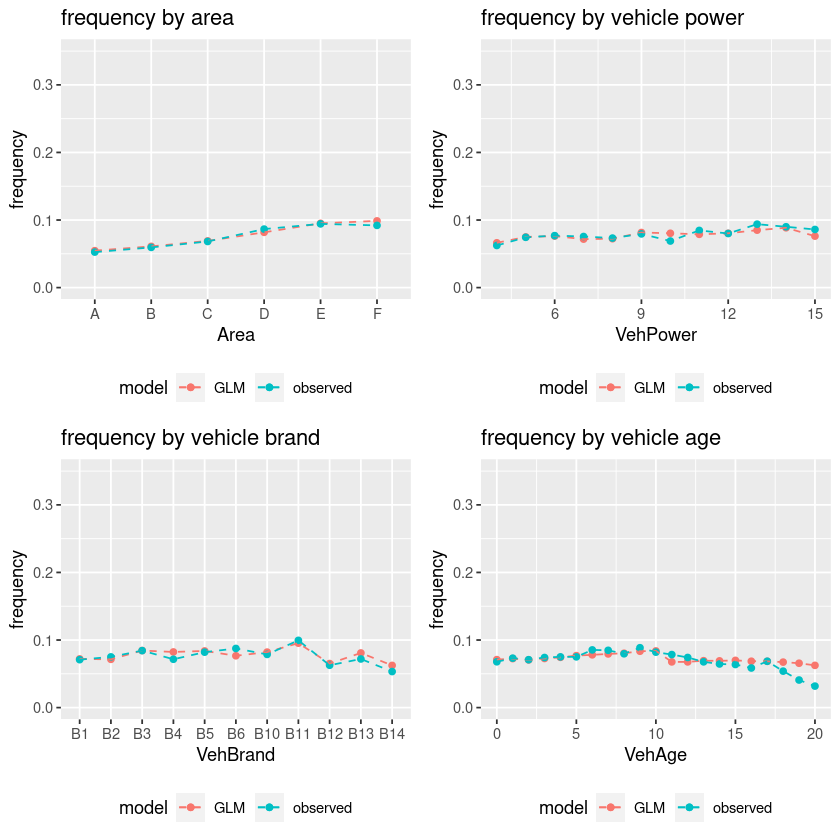

In [24]:
# Area
out <- test %>% group_by(Area) %>%
  summarize(obs = sum(ClaimNb) / sum(Exposure), pred = sum(fitGLM2) / sum(Exposure))
p1 <- plot_freq(out, "Area", "frequency by area", "GLM")
# VehPower
out <- test %>% group_by(VehPower) %>%
  summarize(obs = sum(ClaimNb) / sum(Exposure), pred = sum(fitGLM2) / sum(Exposure))
p2 <- plot_freq(out, "VehPower", "frequency by vehicle power", "GLM")
# VehBrand
out <- test %>% group_by(VehBrand) %>%
  summarize(obs = sum(ClaimNb) / sum(Exposure), pred = sum(fitGLM2) / sum(Exposure))
p3 <- plot_freq(out, "VehBrand", "frequency by vehicle brand", "GLM")
# VehAge
out <- test %>% group_by(VehAge) %>%
  summarize(obs = sum(ClaimNb) / sum(Exposure), pred = sum(fitGLM2) / sum(Exposure))
p4 <- plot_freq(out, "VehAge", "frequency by vehicle age", "GLM")

grid.arrange(p1, p2, p3, p4)

Based on the charts, no issues are detected and the model seems to be well calibrated.

**Exercise:** Perform the calibration with other variables not yet in the charts above.

# Pre-processing Neural Networks

## Introduction

In this chapter, we explain how the data need to be pre-processed to be used in neural networks. It can not be processed in the same way as shown above for GLMs. Further details can be found in this tutorial on [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3226852), chapter 2.

We are going to highlight a few important points in data pre-processing that are necessary for a successful application of networks.

In network modeling the choice of the scale of the feature components may substantially influence the fitting procedure of the predictive model. Therefore, data pre-processing requires careful consideration. We treat unordered categorical (nominal) feature components and continuous (or ordinal) feature components separately. Ordered categorical feature components are treated like continuous ones, where we simply replace the ordered categorical labels by integers. Binary categorical feature components are coded by 0's and 1's for the two binary labels (for binary labels we do not distinguish between ordered and unordered components). Remark that if we choose an anti-symmetric activation function, i.e. $-\phi(x) = \phi(-x)$, we may also set binary
categorical feature components to $\pm 1/2$, which may simplify initialization of optimization
algorithms.

### Unordered (nominal) categorical feature components

We need to transform (nominal) categorical feature components to numerical values. The most commonly used transformations are the so-called **dummy coding** and the **one-hot encoding**. Both methods construct binary representations for categorical labels. For dummy coding one label is chosen as reference level. Dummy coding then uses binary variables to indicate which label a particular policy possesses if it differs from the reference level. In our example we have two unordered categorical feature components, namely VehBrand and Region. We use VehBrand as
illustration. It has 11 different labels $\{B_1, B_{10}, B_{11}, B_{12}, B_{13}, B_{14}, B_2, B_3, B_4, B_5, B_6\}$. We choose
$B_1$ as reference label. Dummy coding then provides the coding scheme below (left). We observe that the 11 labels are replaced by 10-dimensional feature vectors $\{0,1\}^{10}$, with components summing up to either 0 or 1.

![3_cann](Figure_Encoding.PNG)

In contrast to dummy coding, one-hot encoding does not choose a reference level, but uses an indicator for each label. In this way the 11 labels of VehBrand are replaced by the 11 unit vectors. The main difference between dummy coding and one-hot encoding is that the former leads to full rank design matrices, whereas the latter does not. This implies that under one-hot encoding there are identifiability issues in parametrizations. In network modeling identifiability is less important because we typically work in over-parametrized nonconvex optimization problems (with multiple equally good models/parametrizations); on the other hand, identifiability in GLMs is an important feature because one typically tries to solve a convex optimization problem, where the full rank property is important to efficiently  and the (unique) solution.

Remark that other coding schemes could be used for categorical feature components such as Helmert's contrast coding. In classical GLMs the choice of the coding scheme typically does not influence the prediction, however, interpretation of the results may change by considering
a different contrast. In network modeling the choice of the coding scheme may influence the prediction: typically, we exercise an early stopping rule in network calibrations. This early stopping rule and the corresponding result may depend on any chosen modeling strategy, such
as the encoding scheme of categorical feature components.

Remark that dummy coding and one-hot encoding may lead to very high-dimensional input layers in networks, and it provides sparsity in input features. Moreover, the Euclidean distance between any two labels in the one-hot encoding scheme is that same. From natural language
processing (NLP) we have learned that there are more efficient ways of representing categorical feature components, namely, by embedding them into lower-dimensional spaces so that proximity in these spaces has a useful meaning in the regression task. In networks this can be achieved by
so-called embedding layers. In the context of our French MTPL example we refer to our next notebook.

### Continuous feature components

In theory, continuous feature components do not need pre-processing if we choose a sufficiently rich network, because the network may take care of feature components living on different scales. This statement is of purely theoretical value. In practice, continuous feature components need
pre-processing such that they all live on a similar scale and such that they are sufficiently equally distributed across this scale. The reason for this requirement is that the calibration algorithms mostly use gradient descent methods (GDMs). These GDMs only work properly, if
all components live on a similar scale and, thus, all directions contribute equally to the gradient.
Otherwise, the optimization algorithms may get trapped in saddle points or in regions where the gradients are at (also known as vanishing gradient problem). Often, one uses $[-1,+1]$ as the common scale because the/our choice of activation function is focused to that scale.

A popular transformation is the so-called MinMaxScaler. For this transformation we fix each continuous feature component of $x$, say $x_l$, at a time. Denote the minimum and the maximum of the domain of $x_l$ by $m_l$ and $M_l$, respectively. The MinMaxScaler then replaces

![3_cann](Figure_MinMaxScaler.PNG)

In practice, it may happen that the minimum ml or the maximum Ml is not known. In this case one chooses the corresponding minimum and/or maximum of the features in the observed data. For prediction under new features one then needs to keep the original scaling of the initially
observed data, i.e. the one which has been used for model calibration.

Remark that if we have outliers, the above transformations may lead to very concentrated transformed feature components $x_l^*$, $i=1,...,n$, because the outliers may, for instance, dominate the maximum in the MinMaxScaler. In this case, feature components should be transformed
first by a log-transformation or by a quantile transformation so that they become more equally spaced (and robust) across the real line.

### Binary feature components

We observe that binary feature components (e.g. gender) are often embedded in the ML literature into a higher-dimensional space. However, we are of the opinion that this does not make sense. Hence, we suggest to set binary categorical feature components to $\pm 1/2$.

### Summary

As a rule of thumb one could formulate it as follows:
- continuous features $\Rightarrow$ scale to $[-1,+1]$ (if no outliers)
- binary features $\Rightarrow$ set to $\{-1/2,+1/2 \}$
- categorical features:
     * make them numerical $\Rightarrow$ scale to $[-1,+1]$
     * One-hot encoding $\Rightarrow$ no scaling
     * dummy encoding $\Rightarrow$ no scaling
     * embedding $\Rightarrow$ made numerical and no scaling

## Pre-processing functions

In our example we use dummy coding for the feature components VehBrand and Region. We use the MinMaxScaler for Area (after transforming $\{A,...,F\}$ $\mapsto$ $\{1,...,6\}$), VehPower, VehAge (after capping at age 20), DrivAge (after capping at age 90), BonusMalus (after capping at level 150) and Density (after first taking the log-transform). VehGas we transform to $\pm 1/2$ and the volume Exposure $\in (0,1]$ we keep untransformed.

Below the corresponding pre-processing functions:

In [25]:
# MinMax scaler
preprocess_minmax <- function(varData) {
  X <- as.numeric(varData)
  2 * (X - min(X)) / (max(X) - min(X)) - 1
}

# Dummy coding 
preprocess_catdummy <- function(data, varName, prefix) {
  varData <- data[[varName]]
  X <- as.integer(varData)
  n0 <- length(unique(X))
  n1 <- 2:n0
  addCols <- purrr::map(n1, function(x, y) {as.integer(y == x)}, y = X) %>%
    rlang::set_names(paste0(prefix, n1))
  cbind(data, addCols)
}

# Feature pre-processing using MinMax Scaler and Dummy Coding
preprocess_features <- function(data) {
  data %>%
    mutate_at(
      c(AreaX = "Area", VehPowerX = "VehPower", VehAgeX = "VehAge",
        DrivAgeX = "DrivAge", BonusMalusX = "BonusMalus", DensityX = "Density"),
      preprocess_minmax
    ) %>%
    mutate(
      VehGasX = as.integer(VehGas) - 1.5,
      VehBrandX = as.integer(VehBrand) - 1,
      RegionX = as.integer(Region) - 1
    ) %>%
    preprocess_catdummy("VehBrand", "Br") %>%
    preprocess_catdummy("Region", "R")
}

## Execute pre-processing

In [26]:
dat2 <- preprocess_features(dat)

## Inspect the pre-processed data

In [27]:
head(dat2)

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,⋯,R13,R14,R15,R16,R17,R18,R19,R20,R21,R22
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,0.10,D,5,0,55,50,B12,Regular,7.10,⋯,0,0,0,0,0,1,0,0,0,0
2,3,0.77,D,5,0,55,50,B12,Regular,7.10,⋯,0,0,0,0,0,1,0,0,0,0
3,5,0.75,B,6,2,52,50,B12,Diesel,3.99,⋯,0,0,0,0,0,0,0,0,0,0
4,10,0.09,B,7,0,46,50,B12,Diesel,4.33,⋯,0,0,1,0,0,0,0,0,0,0
5,11,0.84,B,7,0,46,50,B12,Diesel,4.33,⋯,0,0,1,0,0,0,0,0,0,0
6,13,0.52,E,6,2,38,50,B12,Regular,8.01,⋯,0,0,0,0,0,0,0,0,0,0


In [28]:
str(dat2)

'data.frame':	678007 obs. of  55 variables:
 $ IDpol      : num  1 3 5 10 11 13 15 17 18 21 ...
 $ Exposure   : num  0.1 0.77 0.75 0.09 0.84 0.52 0.45 0.27 0.71 0.15 ...
 $ Area       : Factor w/ 6 levels "A","B","C","D",..: 4 4 2 2 2 5 5 3 3 2 ...
 $ VehPower   : num  5 5 6 7 7 6 6 7 7 7 ...
 $ VehAge     : num  0 0 2 0 0 2 2 0 0 0 ...
 $ DrivAge    : num  55 55 52 46 46 38 38 33 33 41 ...
 $ BonusMalus : num  50 50 50 50 50 50 50 68 68 50 ...
 $ VehBrand   : Factor w/ 11 levels "B1","B2","B3",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ VehGas     : Factor w/ 2 levels "Diesel","Regular": 2 2 1 1 1 2 2 1 1 1 ...
 $ Density    : num  7.1 7.1 3.99 4.33 4.33 8.01 8.01 4.92 4.92 4.09 ...
 $ Region     : Factor w/ 22 levels "R11","R21","R22",..: 18 18 3 15 15 8 8 20 20 12 ...
 $ ClaimTotal : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ClaimNb    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ group_id   : int  1 1 2 3 3 4 4 5 5 6 ...
 $ fitGLM2    : num  0.00583 0.04486 0.04233 0.00459 0.0428 ...
 $ AreaX      : num  0.2 0.2 -0.

In [29]:
summary(dat2)

     IDpol            Exposure        Area          VehPower     
 Min.   :      1   Min.   :0.002732   A:103957   Min.   : 4.000  
 1st Qu.:1157948   1st Qu.:0.180000   B: 75459   1st Qu.: 5.000  
 Median :2272153   Median :0.490000   C:191880   Median : 6.000  
 Mean   :2621857   Mean   :0.528547   D:151590   Mean   : 6.455  
 3rd Qu.:4046278   3rd Qu.:0.990000   E:137167   3rd Qu.: 7.000  
 Max.   :6114330   Max.   :1.000000   F: 17954   Max.   :15.000  
                                                                 
     VehAge          DrivAge       BonusMalus        VehBrand     
 Min.   : 0.000   Min.   :18.0   Min.   : 50.00   B12    :166024  
 1st Qu.: 2.000   1st Qu.:34.0   1st Qu.: 50.00   B1     :162730  
 Median : 6.000   Median :44.0   Median : 50.00   B2     :159861  
 Mean   : 6.976   Mean   :45.5   Mean   : 59.76   B3     : 53395  
 3rd Qu.:11.000   3rd Qu.:55.0   3rd Qu.: 64.00   B5     : 34753  
 Max.   :20.000   Max.   :90.0   Max.   :150.00   B6     : 28548  
   

## Split train and test data

First, we split the dataset into train and test. Due to the potential grouping of rows in policies we can not just do a random split. For this purpose, we use the function `partition(...)` from the `splitTools` package.

In [30]:
ind <- partition(dat2[["group_id"]], p = c(train = 0.8, test = 0.2), 
                 seed = seed, type = "grouped")
train <- dat2[ind$train, ]
test <- dat2[ind$test, ]

In [31]:
# size of train/test
sprintf("Number of observations (train): %s", nrow(train))
sprintf("Number of observations (test): %s", nrow(test))

# Claims frequency of train/test
sprintf("Empirical frequency (train): %s", round(sum(train$ClaimNb) / sum(train$Exposure), 4))
sprintf("Empirical frequency (test): %s", round(sum(test$ClaimNb) / sum(test$Exposure), 4))

[1] "Number of observations (train): 542331"

[1] "Number of observations (test): 135676"

[1] "Empirical frequency (train): 0.0736"

[1] "Empirical frequency (test): 0.0736"

## Common neural network specifications

In this section, we define objects and parameters which are used for all subsequent neural networks considered, independent of their network structure.

We need to define which components in the pre-processed dataset `dat2` are used as input features. As we have added the pre-processed features appropriate for the neural networks to the original features, we only must use the relevant ones.

In [32]:
# select the feature space

features <- c("AreaX","VehPowerX","VehAgeX","DrivAgeX","BonusMalusX","DensityX","VehGasX",
              "Br2","Br3","Br4","Br5","Br6","Br7","Br8","Br9","Br10","Br11",
              "R2","R3","R4","R5","R6","R7","R8","R9","R10","R11","R12","R13","R14","R15","R16","R17","R18","R19","R20","R21","R22")
print(colnames(train[, features]))

 [1] "AreaX"       "VehPowerX"   "VehAgeX"     "DrivAgeX"    "BonusMalusX"
 [6] "DensityX"    "VehGasX"     "Br2"         "Br3"         "Br4"        
[11] "Br5"         "Br6"         "Br7"         "Br8"         "Br9"        
[16] "Br10"        "Br11"        "R2"          "R3"          "R4"         
[21] "R5"          "R6"          "R7"          "R8"          "R9"         
[26] "R10"         "R11"         "R12"         "R13"         "R14"        
[31] "R15"         "R16"         "R17"         "R18"         "R19"        
[36] "R20"         "R21"         "R22"        


The input to keras requires the train and testing data to be of matrix format, including all features used in the matrix and already correctly pre-processed.

In [33]:
# feature matrix
Xtrain <- as.matrix(train[, features])  # design matrix training sample
Xtest <- as.matrix(test[, features])    # design matrix test sample

# Designing neural networks

The choice of a particular network architecture and its calibration involve many steps. In each of these steps the modeler has to make
certain decisions, and it may require that each of these decisions is revised several times in order to get the best (or more modestly a good) predictive model.

In this section we do not provide an explanation on the ones explicitly used below. We refer to this tutorial on [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3226852), the notebook on FNN and further literature (provided below in the last chapter) to learn more about these hyperparameters and the way to choose the right architecture.

In [34]:
# available optimizers for keras
# https://keras.io/optimizers/
optimizers <- c('sgd', 'adagrad', 'adadelta', 'rmsprop', 'adam', 'adamax', 'nadam')

In [35]:
# homogeneous model (train)
lambda_hom <- sum(train$ClaimNb) / sum(train$Exposure)

# Model 2: Deep plain vanilla neural network (dpNN)

Let us fit a deep neural network. In this chapter, we will not provide as many comments as above, as they remain valid for this chapter as well.

Before fitting and specifiying a neural network, we highly recommend to draw it. This helps in using the `keras` function.

We choose a network with $K=3$ **three hidden layer** and $q_1=20$, $q_1=15$ and $q_1=10$ **neurons**, which looks as follows:

![3_cann](Figure_dpNN.PNG)

The dimension of the input layer is defined by the selected input feature dimension (see above).

## Definition

In [36]:
# define network
q0 <- length(features)   # dimension of features
q1 <- 20                 # number of neurons in first hidden layer
q2 <- 15                 # number of neurons in second hidden layer
q3 <- 10                 # number of neurons in second hidden layer

sprintf("Neural network with K=3 hidden layer")
sprintf("Input feature dimension: q0 = %s", q0)
sprintf("Number of hidden neurons first layer: q1 = %s", q1)
sprintf("Number of hidden neurons second layer: q2 = %s", q2)
sprintf("Number of hidden neurons third layer: q3 = %s", q3)
sprintf("Output dimension: %s", 1)

[1] "Neural network with K=3 hidden layer"

[1] "Input feature dimension: q0 = 38"

[1] "Number of hidden neurons first layer: q1 = 20"

[1] "Number of hidden neurons second layer: q2 = 15"

[1] "Number of hidden neurons third layer: q3 = 10"

[1] "Output dimension: 1"

Below we define the feed-forward shallow network with $q_1$ hidden neurons and hyperbolic tangent activation function, the output has exponential activation function due to the Poisson GLM.

The exposure is included as an offset, and we use the homogeneous model for initializing the output.

In this notebook we do not provide further details on the layers used and the structure, we refer to other notebooks or the references at the end of this notebook. A good reference is the `keras` cheat sheet.

In [37]:
Design <- layer_input(shape = c(q0), dtype = 'float32', name = 'Design') 
LogVol <- layer_input(shape = c(1), dtype = 'float32', name = 'LogVol')

Network <- Design %>%
  layer_dense(units = q1, activation = 'tanh', name = 'layer1') %>%
  layer_dense(units = q2, activation = 'tanh', name = 'layer2') %>%
  layer_dense(units = q3, activation = 'tanh', name = 'layer3') %>%
  layer_dense(units = 1, activation = 'linear', name = 'Network', 
              weights = list(array(0, dim = c(q3, 1)), array(log(lambda_hom), dim = c(1))))

Response <- list(Network, LogVol) %>%
  layer_add(name = 'Add') %>% 
  layer_dense(units = 1, activation = k_exp, name = 'Response', trainable = FALSE,
              weights = list(array(1, dim = c(1, 1)), array(0, dim = c(1))))

model_dp <- keras_model(inputs = c(Design, LogVol), outputs = c(Response))

## Compilation

In [38]:
model_dp %>% compile(
  loss = 'poisson',
  optimizer = optimizers[7]
)

summary(model_dp)

Model: "model"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
Design (InputLayer)       [(None, 38)]      0                                   
________________________________________________________________________________
layer1 (Dense)            (None, 20)        780      Design[0][0]               
________________________________________________________________________________
layer2 (Dense)            (None, 15)        315      layer1[0][0]               
________________________________________________________________________________
layer3 (Dense)            (None, 10)        160      layer2[0][0]               
________________________________________________________________________________
Network (Dense)           (None, 1)         11       layer3[0][0]               
________________________________________________________________________________
LogVol (Input

This summary is crucial for a good understanding of the fitted model. It contains the total number of parameters and shows what the exposure is included as an offset (without training the corresponding weight).

## Fitting

For fitting a keras model and its arguments, we refer to the help of `fit` [here](https://keras.rstudio.com/reference/fit.html). There you find details about the `validation_split` and the `verbose` argument.

If validation_split>0, then the training set is further subdivided into a new training and a validation set. The new training set is used for fitting the model and the validation set is used for (out-of-sample) validation. We emphasize that the validation set is chosen disjointly from the test data, as this latter data may still be used later for the choice of the optimal model (if, for instance, we need to decide between several networks).

With validation_split=0.2 we split the learning data 8:2 into training set and validation set. We fit the network on the training set and we out-of-sample validate it on the validation set.

In [39]:
# select number of epochs and batch.size
epochs <- 300
batch.size <- 10000
validation.split <- 0.2 # set to >0 to see train/validation loss in plot(fit)
verbose <- 1

In [40]:
# expected run-time on Renku 8GB environment around 200 seconds
exec_time <- system.time(
  fit <- model_dp %>% fit(
    list(Xtrain, as.matrix(log(train$Exposure))), as.matrix(train$ClaimNb),
    epochs = epochs,
    batch_size = batch.size,
    validation_split = validation.split,
    verbose = verbose
  )
)
exec_time[1:5]

user.self   sys.self    elapsed user.child  sys.child 
   316.394     38.833     73.953      0.000      0.000

Let us illustrate the decrease of loss during the gradient descent algorithm.
We provide two charts below
- First one: Depending on the argument validation_split you see one curve or two curves (training and validation).
- Second one: only shown if validation_split > 0

The plots help to determine the optimal number of epochs.

`geom_smooth()` using formula 'y ~ x'



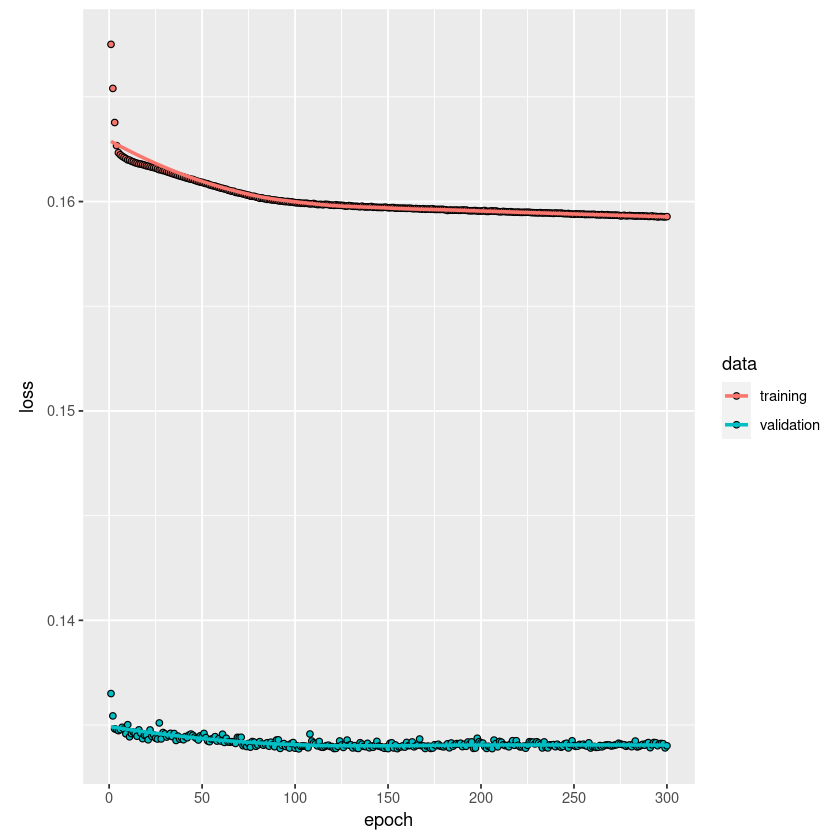

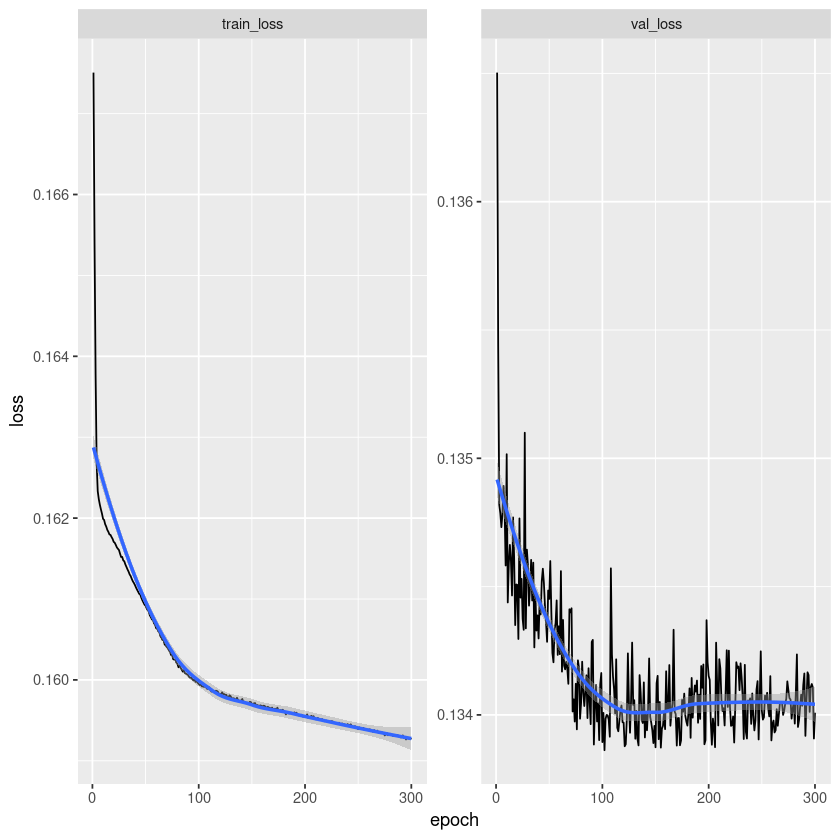

In [41]:
plot(fit)

plot_loss(x=fit[[2]])

You can see the following on the charts:
- $\texttt{validation}\_\texttt{split}=0$: Decrease of the loss during the algorithm for the whole training data. You should expect to see a steady decrease and leveling off at some time. The more epochs, the smaller the loss.
- $\texttt{validation}\_\texttt{split}>0$: decrease of the loss during the algorithm, for training and validation data separately. The loss on the training data is expected to decrease with leveling off, whereas the loss on the validation data decreases and at some point increases again. The epoch with the smallest loss is then a good selection of the optimal number of epochs.

Below, we show two examples how the plots should ideally look like:
* The corresponding tutorial on [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3226852), Figure 14.
* RStudio blog [here](https://blogs.rstudio.com/ai/posts/2017-12-07-text-classification-with-keras/)

as follows, closely copy paste what you find there as comments:

![3_cann](Figure_Loss_RStudio.PNG)
![3_cann](Figure_Loss_Tutorial.PNG)

In the first chart (citing the comment on the page), the training loss decreases with every epoch. That’s what you would expect when running a gradient-descent optimization – the quantity you’re trying to minimize should be less with every iteration. But that isn’t the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we warned against earlier: a model that performs better on the training data isn’t necessarily a model that will do better on data it has never seen before. In precise terms, what you’re seeing is overfitting: after the second epoch, you’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.

In the second chart, the learning data $\mathcal{D}$ is split into a training set and a validation set. The training set is used for fitting the model and the validation set is used for (out-of-sample) validation. We emphasize that we choose the validation
set disjointly from the test data $\mathcal{T}$. 
In the second figure the learning data is split 8:2 into training set (blue color) and validation set (green color). The network is fit on the training set and it is validated on the validation set. We observe that the model starts to over-fit to the learning data after roughly 150 epochs, since the validation loss (green color) starts to increase thereafter.

Comments:
* The results for this data is quite clear and hence we can find the optimal number of epochs.

## Validation

In [42]:
# Validation: Poisson deviance
train$fitdpNN <- as.vector(model_dp %>% predict(list(Xtrain, as.matrix(log(train$Exposure)))))
test$fitdpNN <- as.vector(model_dp %>% predict(list(Xtest, as.matrix(log(test$Exposure)))))

sprintf("100 x Poisson deviance shallow network (train): %s", PoissonDeviance(train$fitdpNN, train$ClaimNb))
sprintf("100 x Poisson deviance shallow network (test): %s", PoissonDeviance(test$fitdpNN, test$ClaimNb))

# average frequency
sprintf("Average frequency (test): %s", round(sum(test$fitdpNN) / sum(test$Exposure), 4))

[1] "100 x Poisson deviance shallow network (train): 23.6492673810763"

[1] "100 x Poisson deviance shallow network (test): 24.0045442469574"

[1] "Average frequency (test): 0.0739"

In [43]:
trainable_params <- sum(unlist(lapply(model_dp$trainable_weights, k_count_params)))
df_cmp %<>% bind_rows(
  data.frame(model = "M2: Deep Plain Network", epochs = epochs,
             run_time = round(exec_time[[3]], 0), parameters = trainable_params,
             in_sample_loss = round(PoissonDeviance(train$fitdpNN, train$ClaimNb), 4),
             out_sample_loss = round(PoissonDeviance(test$fitdpNN, test$ClaimNb), 4),
             avg_freq = round(sum(test$fitdpNN) / sum(test$Exposure), 4)
  ))
df_cmp

model,epochs,run_time,parameters,in_sample_loss,out_sample_loss,avg_freq
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M1: GLM,NA,21,48,24.0875,24.1666,0.0737
M2: Deep Plain Network,300,74,1266,23.6493,24.0045,0.0739


## Calibration

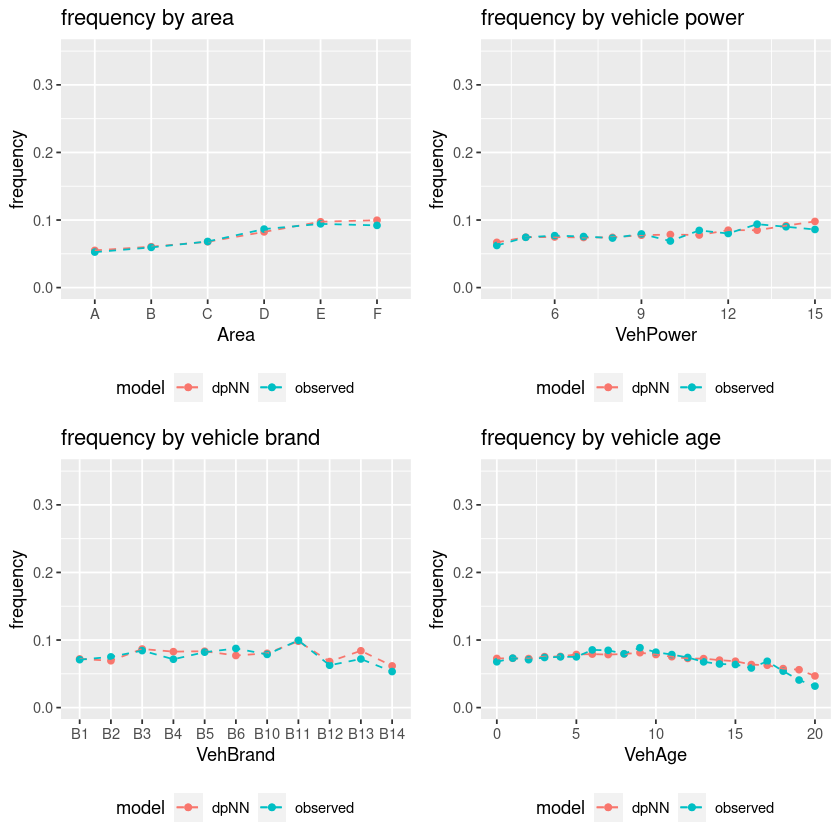

In [44]:
# Area
out <- test %>% group_by(Area) %>%
  summarize(obs = sum(ClaimNb) / sum(Exposure), pred = sum(fitdpNN) / sum(Exposure))
p1 <- plot_freq(out, "Area", "frequency by area", "dpNN")
# VehPower
out <- test %>% group_by(VehPower) %>%
  summarize(obs = sum(ClaimNb) / sum(Exposure), pred = sum(fitdpNN) / sum(Exposure))
p2 <- plot_freq(out, "VehPower", "frequency by vehicle power", "dpNN")
# VehBrand
out <- test %>% group_by(VehBrand) %>%
  summarize(obs = sum(ClaimNb) / sum(Exposure), pred = sum(fitdpNN) / sum(Exposure))
p3 <- plot_freq(out, "VehBrand", "frequency by vehicle brand", "dpNN")
# VehAge
out <- test %>% group_by(VehAge) %>%
  summarize(obs = sum(ClaimNb) / sum(Exposure), pred = sum(fitdpNN) / sum(Exposure))
p4 <- plot_freq(out, "VehAge", "frequency by vehicle age", "dpNN")

grid.arrange(p1, p2, p3, p4)

Is worthwhile to remark that the fit is quite close to the observations and that the neural networks smooths out some jumps in the observations for VehAge which is in line with expectations.

**Exercise**: Change the number of neurons, compare the number of parameters and the fitted results.

**Exercise:** Change the input feature space by removing for example Area, VehPower from the input and compare the number of network parameters and the fitted results.

**Exercise:** Read the documentation to the optimizers and run the subsequent analysis with different optimizers and compare the results.

**Exercise**: Change the random seeds (at the beginning of the tutorial) and compare the results.

**Exercise** Run the same analysis and see if you can fully reproduce the results. What do you conclude from that?

**Exercise:** Change the activiation function (only where it is appropriate) and compare the results.

**Exercise:** Change the validation.split and verbose argument and see the difference in the fitting of the model.

# Model 3: Neural Network with Embeddings (EmbNN)

![3_cann](Figure_embNN.PNG)

The network in the above figure (middle) shows for each feature component one single neuron in the input layer (blue, green and magenta colors), thus, an input layer of dimension $q0 = 9$. However, we have two categorical feature components $\texttt{VehBrand}$ and $\texttt{Region}$ with more than 2 different categorical labels. One-hot encoding requires that these two components receive 11 and 22 input neurons, respectively. Thus, one-hot encoding implies that the input layer has dimension $q0$ (if we assume that all other feature components need one single input neuron). This results in dimension r for the network. This is exactly the network illustrated in the figure (lhs), with one-hot encoding for $\texttt{VehBrand}$ in green color and one-hot encoding for $\texttt{Region}$ in magenta color. Brute-force network calibration then simply fits this model using a version of the gradient descent algorithm.

We should ask ourselves whether the brute-force implementation of categorical feature components using one-hot encoding is optimal, since it seems to introduce an excessive number of network parameters. There is a second reason why one-hot encoding seems to be sub-optimal for our purposes. In general, we would like to identify (cluster) labels that are similar for the regression modeling problem. This is not the case with one-hot encoding. If we consider, for instance, the 11 vehicle brands $\mathcal{B} = \{B_1, B_{10},...,B_6\}$, one-hot encoding assigns a different unit vector to each VehBrand. For two different brands $\texttt{VehBrand1} \ne \texttt{VehBrand2}$ we always receive a distance of $\sqrt2$, thus, the (Euclidean) distance between all vehicle brands is the same under one-hot encoding. In tis section we present embedding layers which aim at embedding categorical feature components
into low dimensional Euclidean spaces, clustering labels that are more similar for the regression modeling problem.

Recently, it has been proposed to use embedding layers for categorical feature components, and he has noted that this can lead to better results compared to one-hot encoding. Embedding layers are very common in natural language processing (NLP). Embedding layers are used in NLP in order to represent words by numerical coordinates in a low dimensional space. This approach has two advantages. First, the dimension is reduced (compared to one-hot encoding with a large sparse matrix). Second, similarities between words can be examined and provide additional insights to one-hot encoding.

In order not to rewrite everything, below an exact from the tutorial on the functioning of embeddings:

![3_cann](Figure_embMotivation.PNG)

We are now going to compare the brute-force one-hot encoding and embedding layers. We choose a network of depth $K = 3$ as shown above, having hidden neurons $(q_1, q_2, q_3) = (20, 15, 10)$, and using one-hot encoding for the feature components  $\texttt{VehBrand}$ and $\texttt{Region}$, this network is illustrated in the figure above.

## Definition

Below we define the non-embedded network parameters.

In [45]:
# definition of non-embedded features
features <- c("AreaX", "VehPowerX", "VehAgeX", "DrivAgeX", "BonusMalusX", "VehGasX", "DensityX")
q0 <- length(features)   # number of non-embedded input features
q1 <- 20                 # number of neurons in first hidden layer
q2 <- 15                 # number of neurons in second hidden layer
q3 <- 10                 # number of neurons in second hidden layer

sprintf("Neural network with K=3 hidden layer")
sprintf("non-embedded feature dimension: q0 = %s", q0)
sprintf("Number of hidden neurons first layer: q1 = %s", q1)
sprintf("Number of hidden neurons second layer: q2 = %s", q2)
sprintf("Number of hidden neurons third layer: q3 = %s", q3)
sprintf("Output dimension: %s", 1)

[1] "Neural network with K=3 hidden layer"

[1] "non-embedded feature dimension: q0 = 7"

[1] "Number of hidden neurons first layer: q1 = 20"

[1] "Number of hidden neurons second layer: q2 = 15"

[1] "Number of hidden neurons third layer: q3 = 10"

[1] "Output dimension: 1"

In [46]:
# training data
Xtrain <- as.matrix(train[, features])  # design matrix training sample
VehBrandtrain <- as.matrix(train$VehBrandX)
Regiontrain <- as.matrix(train$RegionX)
Ytrain <- as.matrix(train$ClaimNb)

# testing data
Xtest <- as.matrix(test[, features])    # design matrix test sample
VehBrandtest <- as.matrix(test$VehBrandX)
Regiontest <- as.matrix(test$RegionX)
Ytest <- as.matrix(test$ClaimNb)

**The below lines differentiate the embedded NN from the embedded CANN**



In [47]:
# choosing the right volumes for EmbNN
Vtrain <- as.matrix(log(train$Exposure))
Vtest <- as.matrix(log(test$Exposure))
lambda_hom <- sum(train$ClaimNb) / sum(train$Exposure)

sprintf("Empirical frequency (train): %s", round(lambda_hom, 4))

[1] "Empirical frequency (train): 0.0736"

**The above lines differentiate the embedded NN from the embedded CANN**



Below we define the non-embedded network parameters.

In [48]:
# set the number of levels for the embedding variables
VehBrandLabel <- length(unique(train$VehBrandX))
RegionLabel <- length(unique(train$RegionX))

sprintf("Embedded VehBrand feature dimension: %s", VehBrandLabel)
sprintf("Embedded Region feature dimension: %s", RegionLabel)

[1] "Embedded VehBrand feature dimension: 11"

[1] "Embedded Region feature dimension: 22"

Below we define with $d$ the number of embedding layers. $d=2$ corresponds to the network structure above (rhs). We use the same embedding dimension for both categorical feature components.

In [49]:
# dimension embedding layers for categorical features
d <- 2 

The code for designing the network architecture with embedding layers for the categorical explanatory variables VehBrand and Region is given below.

In [50]:
# define the network architecture
Design   <- layer_input(shape = c(q0),  dtype = 'float32', name = 'Design')
VehBrand <- layer_input(shape = c(1),   dtype = 'int32', name = 'VehBrand')
Region   <- layer_input(shape = c(1),   dtype = 'int32', name = 'Region')
LogVol   <- layer_input(shape = c(1),   dtype = 'float32', name = 'LogVol')

BrandEmb <- VehBrand %>%
  layer_embedding(input_dim = VehBrandLabel, output_dim = d, input_length = 1, name = 'BrandEmb') %>%
  layer_flatten(name='Brand_flat')

RegionEmb <- Region %>%
  layer_embedding(input_dim = RegionLabel, output_dim = d, input_length = 1, name = 'RegionEmb') %>%
  layer_flatten(name='Region_flat')

Network <- list(Design, BrandEmb, RegionEmb) %>% layer_concatenate(name = 'concate') %>%
  layer_dense(units = q1, activation = 'tanh', name = 'hidden1') %>%
  layer_dense(units = q2, activation = 'tanh', name = 'hidden2') %>%
  layer_dense(units = q3, activation = 'tanh', name = 'hidden3') %>%
  layer_dense(units = 1, activation = 'linear', name = 'Network',
              weights = list(array(0, dim = c(q3,1)), array(log(lambda_hom), dim = 1)))

Response <- list(Network, LogVol) %>% layer_add(name = 'Add') %>%
  layer_dense(units = 1, activation = k_exp, name = 'Response', trainable = FALSE,
              weights = list(array(1, dim = c(1,1)), array(0, dim = 1)))

model_nn <- keras_model(inputs = c(Design, VehBrand, Region, LogVol), outputs = c(Response))

## Compilation



Let us compile the model, using the Poisson deviance loss function as objective function, and nadam as the optimizer, and we provide a summary of the network structure.

For further details, we refer to the help file of `compile` [here](https://keras.rstudio.com/reference/compile.html).

In [51]:
model_nn %>% compile(
  loss = 'poisson',
  optimizer = optimizers[7]
)

summary(model_nn)

Model: "model_1"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
VehBrand (InputLayer)     [(None, 1)]       0                                   
________________________________________________________________________________
Region (InputLayer)       [(None, 1)]       0                                   
________________________________________________________________________________
BrandEmb (Embedding)      (None, 1, 2)      22       VehBrand[0][0]             
________________________________________________________________________________
RegionEmb (Embedding)     (None, 1, 2)      44       Region[0][0]               
________________________________________________________________________________
Design (InputLayer)       [(None, 7)]       0                                   
________________________________________________________________________________
Brand_flat 

This summary is crucial for a good understanding of the fitted model. It contains the total number of parameters and shows what the exposure is included as an offset (without training the corresponding weight).

## Fitting



In [52]:
# select number of epochs and batch.size
epochs <- 500
batch_size <- 10000
validation_split <- 0.2 # set to >0 to see train/validation loss in plot(fit)
verbose <- 1

In [53]:
# fitting the neural network
# expected run-time on Renku 8GB environment around 50 seconds
exec_time <- system.time(
  fit <- model_nn %>% fit(
      list(Xtrain, VehBrandtrain, Regiontrain, Vtrain), Ytrain,
      epochs = epochs,
      batch_size = batch_size,
      verbose = verbose,
      validation_split = validation_split
  )
)
exec_time[1:5]

user.self   sys.self    elapsed user.child  sys.child 
   408.677     58.930    124.513      0.000      0.000

`geom_smooth()` using formula 'y ~ x'



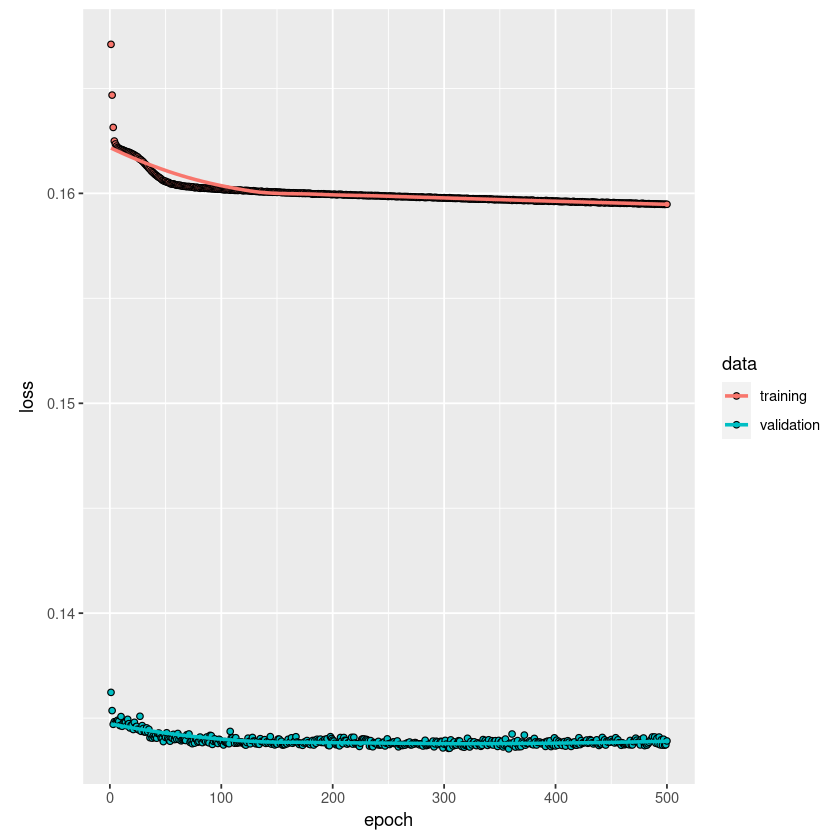

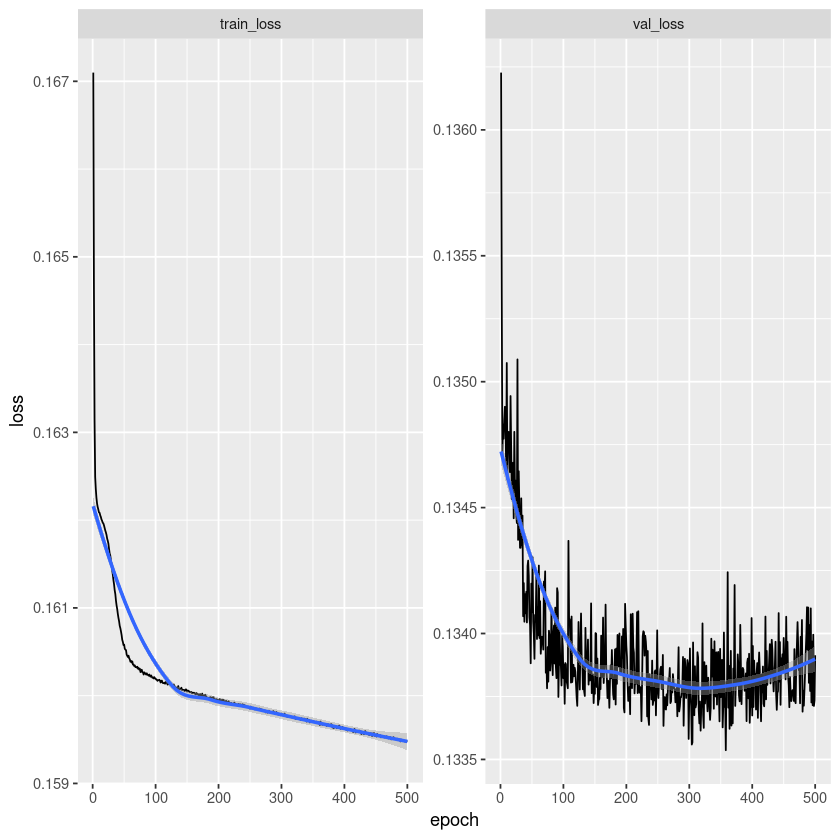

In [54]:
plot(fit)

plot_loss(x=fit[[2]])

## Evaluation

In [55]:
# calculating the predictions
train$fitNN <- as.vector(model_nn %>% predict(list(Xtrain, VehBrandtrain, Regiontrain, Vtrain)))
test$fitNN <- as.vector(model_nn %>% predict(list(Xtest, VehBrandtest, Regiontest, Vtest)))

# average in-sample and out-of-sample losses (in 10^(-2))
sprintf("100 x Poisson deviance shallow network (train): %s", PoissonDeviance(train$fitNN, as.vector(unlist(train$ClaimNb))))
sprintf("100 x Poisson deviance shallow network (test): %s", PoissonDeviance(test$fitNN, as.vector(unlist(test$ClaimNb))))

# average frequency
sprintf("Average frequency (test): %s", round(sum(test$fitNN) / sum(test$Exposure), 4))

[1] "100 x Poisson deviance shallow network (train): 23.6859398327815"

[1] "100 x Poisson deviance shallow network (test): 23.8738697785192"

[1] "Average frequency (test): 0.0765"

In [56]:
# extract the number of trainable parameters from the keras model
tot_params <- count_params(model_nn)
trainable_params <- sum(unlist(lapply(model_nn$trainable_weights, k_count_params)))
nontrainable_params <- sum(unlist(lapply(model_nn$non_trainable_weights, k_count_params)))

In [57]:
df_cmp %<>% bind_rows(
  data.frame(model = "M3: EmbNN", epochs = epochs,
             run_time = round(exec_time[[3]], 0), parameters = trainable_params,
             in_sample_loss = round(PoissonDeviance(train$fitNN, as.vector(unlist(train$ClaimNb))), 4),
             out_sample_loss = round(PoissonDeviance(test$fitNN, as.vector(unlist(test$ClaimNb))), 4),
             avg_freq = round(sum(test$fitNN) / sum(test$Exposure), 4)
  ))
df_cmp

model,epochs,run_time,parameters,in_sample_loss,out_sample_loss,avg_freq
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M1: GLM,NA,21,48,24.0875,24.1666,0.0737
M2: Deep Plain Network,300,74,1266,23.6493,24.0045,0.0739
M3: EmbNN,500,125,792,23.6859,23.8739,0.0765


## Visualization

### Visualize exposure and observed frequency

Subsequently, we show the observed marginal frequencies and the underlying volumes.

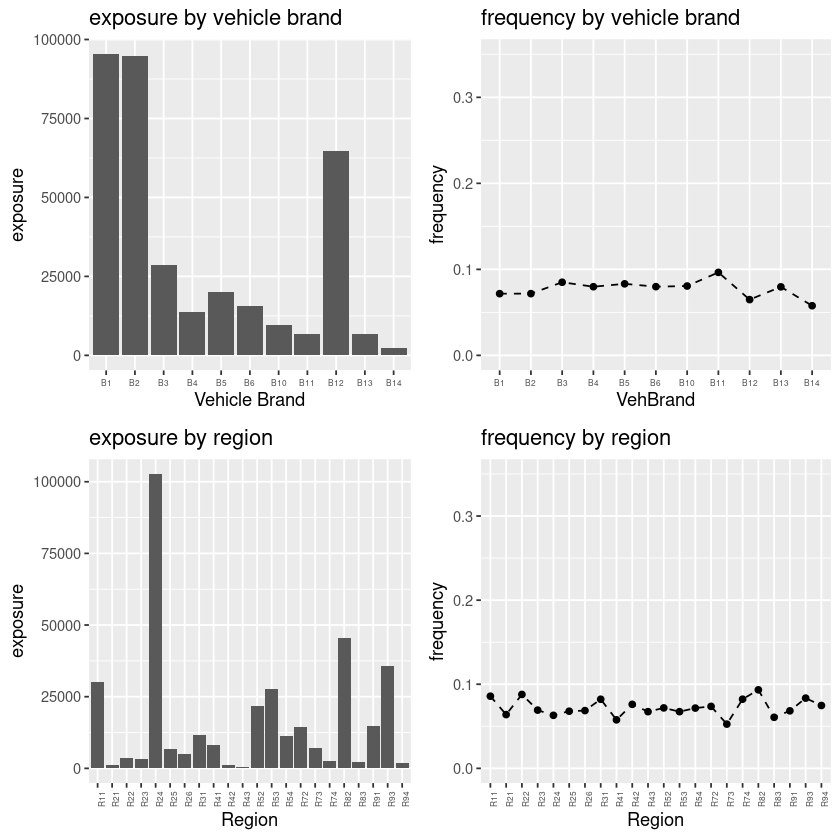

In [58]:
# VehBrand
p1 <- ggplot(dat, aes(VehBrand)) +
  geom_bar(aes(weight = Exposure)) +
  labs(x = "Vehicle Brand", y = "exposure", title = "exposure by vehicle brand") +
  theme(axis.text.x = element_text(size = 5))

out <- dat %>% group_by(VehBrand) %>% summarize(freq = mean(ClaimNb) / mean(Exposure))
p2 <- ggplot(out, aes(x = VehBrand, y = freq, group = 1)) +
  geom_point() + geom_line(linetype = "dashed") +
  ylim(0, 0.35) + labs(x = "VehBrand", y = "frequency", title = "frequency by vehicle brand") +
  theme(axis.text.x = element_text(size = 5))

# Region
p3 <- ggplot(dat, aes(Region)) +
  geom_bar(aes(weight = Exposure)) +
  labs(x = "Region", y = "exposure", title = "exposure by region") +
  theme(axis.text.x = element_text(angle = 90, size = 5))

out <- dat %>% group_by(Region) %>% summarize(freq = mean(ClaimNb) / mean(Exposure))
p4 <- ggplot(out, aes(x = Region, y = freq, group = 1)) +
  geom_point() + geom_line(linetype = "dashed") +
  ylim(0, 0.35) + labs(x = "Region", y = "frequency", title = "frequency by region") +
  theme(axis.text.x = element_text(angle = 90, size = 5))

grid.arrange(p1, p2, p3, p4)

### Visualize embeddings



The embedding layers have an other advantage, namely, we can graphically illustrate the findings of the network (at least if $d$ is small). This is very useful in NLP as it allows us to explore similar words graphically in 2 or 3 dimensions, after some further dimension reduction techniques have
been applied.

We illustrate below the resulting embedding weights. We observe clustering in both categorical labels, which indicates that some labels could be merged. For $\texttt{VehBrand}$ we observe that car brand $B_{12}$ is diferent from all other car brands, $B_{10}$ and $B_{11}$ seem to have similarities, and the remaining car brands cluster. For $\texttt{Region}$ the result is more diverse.

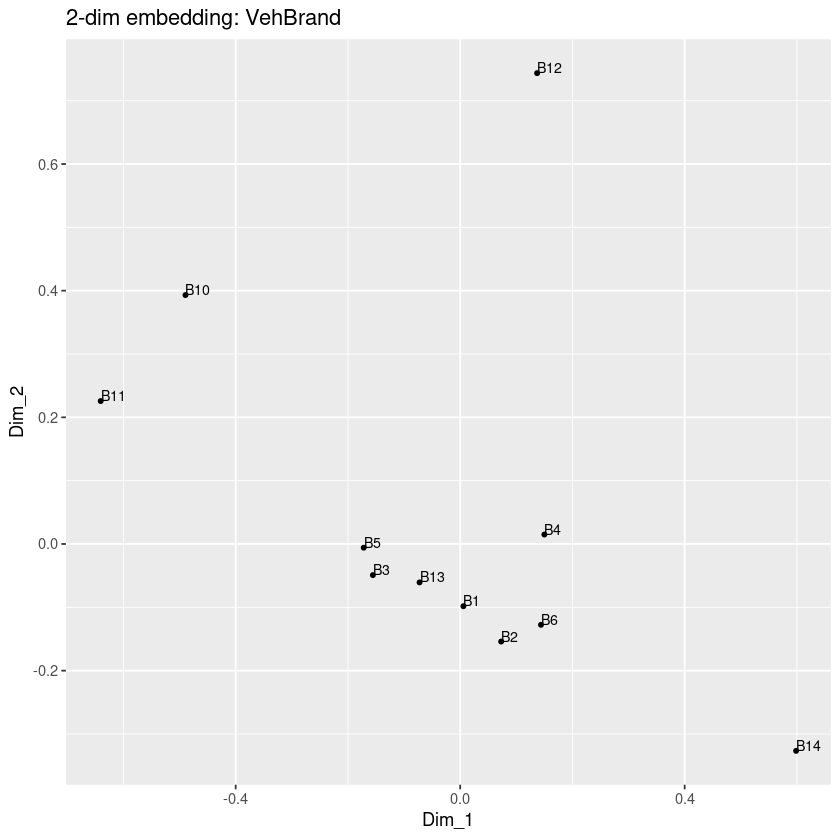

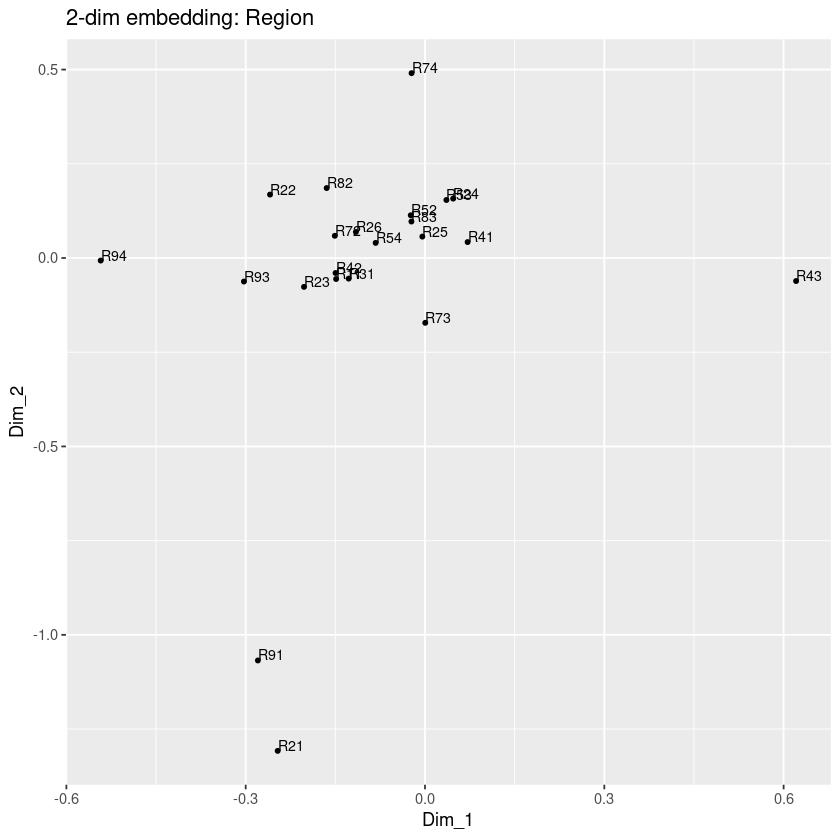

In [59]:
## VehBrand
emb_Brand <- (model_nn$get_layer("BrandEmb") %>% get_weights())[[1]] %>%
  as.data.frame() %>%
  add_column(levels(factor(dat2$VehBrand))) %>%
  rlang::set_names(c("Dim_1", "Dim_2", "Label"))

ggplot(emb_Brand, aes(x = Dim_1, y = Dim_2, label = Label)) + 
  geom_point(size = 1) + 
  geom_text(aes(label = Label), hjust = 0, vjust = 0, size = 3) + 
  ggtitle("2-dim embedding: VehBrand")

## Region
emb_Region <- (model_nn$get_layer("RegionEmb") %>% get_weights())[[1]] %>%
  as.data.frame() %>%
  add_column(levels(factor(dat2$Region))) %>%
  rlang::set_names(c("Dim_1", "Dim_2", "Label"))

ggplot(emb_Region, aes(x = Dim_1, y = Dim_2, label = Label)) + 
  geom_point(size = 1) + 
  geom_text(aes(label = Label), hjust = 0, vjust = 0, size = 3) + 
  ggtitle("2-dim embedding: Region")


## Calibration



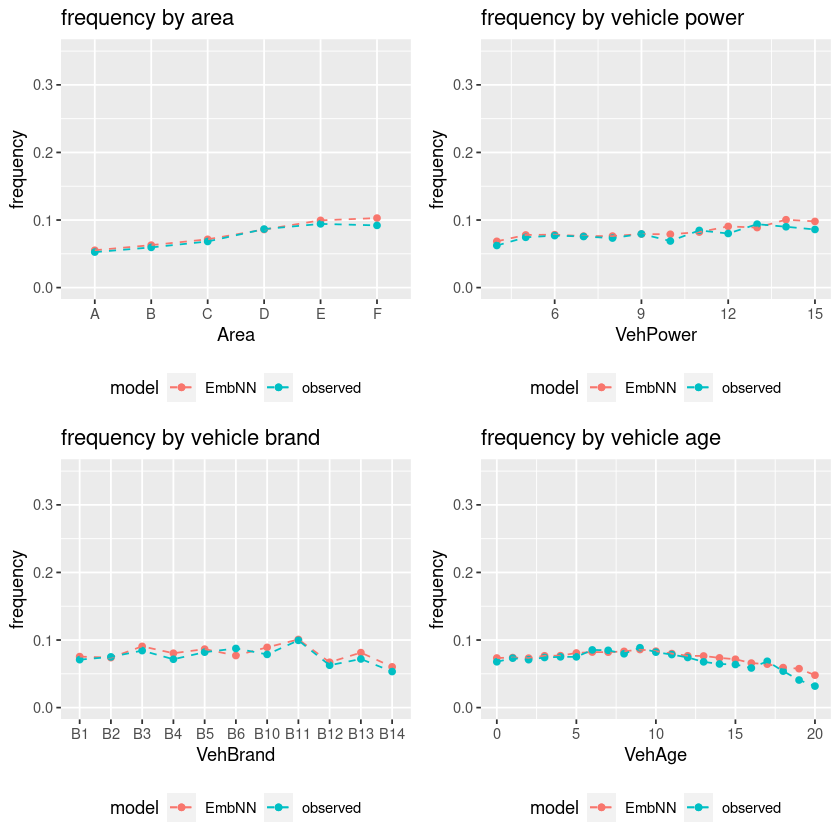

In [60]:
# Area
out <- test %>% group_by(Area) %>% summarize(obs = sum(ClaimNb) / sum(Exposure),
                                             pred = sum(fitNN) / sum(Exposure))
p1 <- plot_freq(out, "Area", "frequency by area", "EmbNN")
# VehPower
out <- test %>% group_by(VehPower) %>% summarize(obs = sum(ClaimNb) / sum(Exposure),
                                                 pred = sum(fitNN) / sum(Exposure))
p2 <- plot_freq(out, "VehPower", "frequency by vehicle power", "EmbNN")
# VehBrand
out <- test %>% group_by(VehBrand) %>% summarize(obs = sum(ClaimNb) / sum(Exposure),
                                                 pred = sum(fitNN) / sum(Exposure))
p3 <- plot_freq(out, "VehBrand", "frequency by vehicle brand", "EmbNN")
# VehAge
out <- test %>% group_by(VehAge) %>% summarize(obs = sum(ClaimNb) / sum(Exposure),
                                               pred = sum(fitNN) / sum(Exposure))
p4 <- plot_freq(out, "VehAge", "frequency by vehicle age", "EmbNN")

grid.arrange(p1, p2, p3, p4)

**Exercise:** Change the embedding dimension $d$ to another figure and compare the results.

**Exercise:** Change the embedding dimension $d$ to $>2$, and apply a dimension reduction technique to still plot the 2-dimensional charts.

**Exercise:** There are additional variables (which we made numerical above like Area) that could be candidates to be embedded. Choose some of them, embed them and compare the results.

We can draw the following conclusions:
- The networks improve the GLM results in terms of out-of-sample losses because we have not been investing suffcient efforts in finding the optimal GLM with respect to feature engineering and potential interactions.
- From the analysis in this section we prefer embedding layers over one-hot encoding for categorical feature components, however, at the price of longer run times.
- Besides that embedding layers might improve the out-of-sample performance of the network they allow us to visually identify relationships between the different levels of categorical inputs.
- The downsides of networks are that calibrations lead to volatile average frequency estimates and bias fluctuations.

# Model 4: Combined Actuarial Neural Network (CANN)

In this section we combine the classical GLM and the network. This approach can be seen as rather universal because it applies to many other parametric regression problems. The idea is to nest the GLM into a network architecture.

![3_cann](Figure_cann_ass.PNG)

The CANN approach of Model Assumptions 3.1 is illustrated below. The skip connection in orange color contains the GLM (note that for the moment we neglect that categorical feature components may use a different encoding for the GLM and the network parts).

![3_cann](Figure_cann_skip.PNG)

We provide some remarks.

- Formula (3.1) combines our previous two models, in particular, it embeds the GLM into a network architecture by packing it into a so-called skip connection that directly links the input layer to the output layer, see orange arrow in the above figure. Skip connections are used in deep networks because they have good calibration properties, potentially avoiding the vanishing gradient problem. We use the skip connection for a different purpose here.
- The two models are combined in the output layer by a (simple) addition. This addition makes one of the intercepts $\beta_0$ and $w^{(K+1)}_0$ superfluous. Therefore, we typically fix one of the intercepts, in most cases $\beta_0$, and we only train the other intercept, say, $w^{(K+1)}_0$ in the
new network parameter $\vartheta = (\beta,\theta)$ of regression function (3.1).
- Regression function (3.1) requires that the GLM and the network model are defined on the same feature space $\mathcal{X}$. This may require that we merge the feature space of the GLM model and the network approach, and not both parts in the regression function (3.1) may consider all components of that merged feature space, for instance, when GLM considers a component in a dummy coding representation and the network part considers the same component in a continuous coding fashion.

The second important ingredient is the following idea.

![3_cann](Figure_cann_init.PNG)

Note that initialization (3.2) exactly provides the MLE prediction of the GLM part of the CANN model (3.1), i.e. it minimizes the Poisson deviance loss. If we start the gradient descent algorithm for fitting the CANN model (3.1) in this initial value, and if we use the Poisson deviance loss as objective function, then the algorithm explores the network architecture for additional model structure that is not present in the GLM and which lowers the initial Poisson deviance loss related to the (initial) network parameter. In this way we obtain an improvement of the GLM by network features. This provides a more systematic way of using network architectures to improve the GLM. We will highlight this with several examples.

![3_cann](Figure_cann_variants.PNG)

In the case of the Poisson distribution we can substantially simplify the CANN implementation. From (3.3) we see that if the GLM part is non-trainable with MLE, then we can merge this term with the given volumes $vi$. We observe that this code has become much simpler and shown below.

## Definition

Below we define the non-embedded network parameters.

In [61]:
# definition of non-embedded features
features <- c("AreaX", "VehPowerX", "VehAgeX", "DrivAgeX", "BonusMalusX", "VehGasX", "DensityX")
q0 <- length(features)   # number of non-embedded input features
q1 <- 20                 # number of neurons in first hidden layer
q2 <- 15                 # number of neurons in second hidden layer
q3 <- 10                 # number of neurons in second hidden layer

sprintf("Neural network with K=3 hidden layer")
sprintf("non-embedded feature dimension: q0 = %s", q0)
sprintf("Number of hidden neurons first layer: q1 = %s", q1)
sprintf("Number of hidden neurons second layer: q2 = %s", q2)
sprintf("Number of hidden neurons third layer: q3 = %s", q3)
sprintf("Output dimension: %s", 1)

[1] "Neural network with K=3 hidden layer"

[1] "non-embedded feature dimension: q0 = 7"

[1] "Number of hidden neurons first layer: q1 = 20"

[1] "Number of hidden neurons second layer: q2 = 15"

[1] "Number of hidden neurons third layer: q3 = 10"

[1] "Output dimension: 1"

In [62]:
# training data
Xtrain <- as.matrix(train[, features])  # design matrix training sample
VehBrandtrain <- as.matrix(train$VehBrandX)
Regiontrain <- as.matrix(train$RegionX)
Ytrain <- as.matrix(train$ClaimNb)

# testing data
Xtest <- as.matrix(test[, features])    # design matrix test sample
VehBrandtest <- as.matrix(test$VehBrandX)
Regiontest <- as.matrix(test$RegionX)
Ytest <- as.matrix(test$ClaimNb)

**The below lines differentiate the embedded NN from the embedded CANN**



In [63]:
# choosing the right volumes for CANN (difference to NN above!)
Vtrain <- as.matrix(log(train$fitGLM2))
Vtest <- as.matrix(log(test$fitGLM2))
lambda_hom <- sum(train$ClaimNb) / sum(train$fitGLM2)

sprintf("Empirical frequency (train): %s", round(lambda_hom, 4))

[1] "Empirical frequency (train): 1"

**The above lines differentiate the embedded NN from the embedded CANN**



Below we define the non-embedded network parameters.

In [64]:
# set the number of levels for the embedding variables
VehBrandLabel <- length(unique(train$VehBrandX))
RegionLabel <- length(unique(train$RegionX))

sprintf("Embedded VehBrand feature dimension: %s", VehBrandLabel)
sprintf("Embedded Region feature dimension: %s", RegionLabel)

[1] "Embedded VehBrand feature dimension: 11"

[1] "Embedded Region feature dimension: 22"

Below we define with $d$ the number of embedding layers. $d=2$ corresponds to the network structure above (rhs). We use the same embedding dimension for both categorical feature components.

In [65]:
# dimensions embedding layers for categorical features
d <- 2        

The code for designing the network architecture with embedding layers for the categorical explanatory variables VehBrand and Region is given below.

In [66]:
# define the network architecture
Design   <- layer_input(shape = c(q0),  dtype = 'float32', name = 'Design')
VehBrand <- layer_input(shape = c(1),   dtype = 'int32', name = 'VehBrand')
Region   <- layer_input(shape = c(1),   dtype = 'int32', name = 'Region')
LogVol   <- layer_input(shape = c(1),   dtype = 'float32', name = 'LogVol')

BrandEmb <- VehBrand %>%
  layer_embedding(input_dim = VehBrandLabel, output_dim = d, input_length = 1, name = 'BrandEmb') %>%
  layer_flatten(name = 'Brand_flat')

RegionEmb <- Region %>%
  layer_embedding(input_dim = RegionLabel, output_dim = d, input_length = 1, name = 'RegionEmb') %>%
  layer_flatten(name = 'Region_flat')

Network <- list(Design, BrandEmb, RegionEmb) %>% layer_concatenate(name = 'concate') %>%
  layer_dense(units = q1, activation = 'tanh', name = 'hidden1') %>%
  layer_dense(units = q2, activation = 'tanh', name = 'hidden2') %>%
  layer_dense(units = q3, activation = 'tanh', name = 'hidden3') %>%
  layer_dense(units = 1, activation = 'linear', name = 'Network',
              weights = list(array(0, dim = c(q3, 1)), array(log(lambda_hom), dim = 1)))

Response <- list(Network, LogVol) %>% layer_add(name = 'Add') %>%
  layer_dense(units = 1, activation = k_exp, name = 'Response', trainable = FALSE,
              weights = list(array(1, dim = c(1, 1)), array(0, dim = 1)))

model_cann <- keras_model(inputs = c(Design, VehBrand, Region, LogVol), outputs = c(Response))


## Compilation



In [67]:
model_cann %>% compile(
  loss = 'poisson',
  optimizer = optimizers[7]
)

summary(model_cann)

Model: "model_2"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
VehBrand (InputLayer)     [(None, 1)]       0                                   
________________________________________________________________________________
Region (InputLayer)       [(None, 1)]       0                                   
________________________________________________________________________________
BrandEmb (Embedding)      (None, 1, 2)      22       VehBrand[0][0]             
________________________________________________________________________________
RegionEmb (Embedding)     (None, 1, 2)      44       Region[0][0]               
________________________________________________________________________________
Design (InputLayer)       [(None, 7)]       0                                   
________________________________________________________________________________
Brand_flat 

This summary is crucial for a good understanding of the fitted model. It contains the total number of parameters and shows what the exposure is included as an offset (without training the corresponding weight).

## Fitting



In [68]:
# select number of epochs and batch.size
epochs <- 500
batch_size <- 10000
validation_split <- 0.2 # set to >0 to see train/validation loss in plot(fit)
verbose <- 1

In [69]:
# fitting the neural network
# expected run-time on Renku 8GB environment around 50 seconds
exec_time <- system.time(
  fit <- model_cann %>% fit(list(Xtrain, VehBrandtrain, Regiontrain, Vtrain), Ytrain,
                       epochs = epochs, 
                       batch_size = batch_size,
                       verbose = verbose,
                       validation_split = validation_split)
)
exec_time[1:5]

user.self   sys.self    elapsed user.child  sys.child 
   395.739     57.862    120.956      0.000      0.000

`geom_smooth()` using formula 'y ~ x'



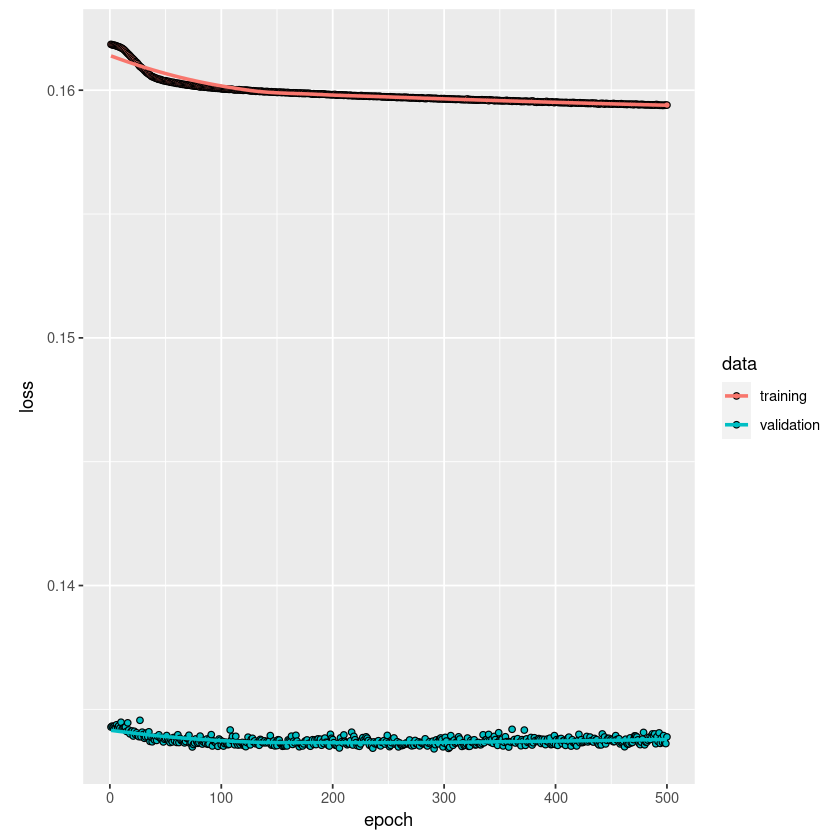

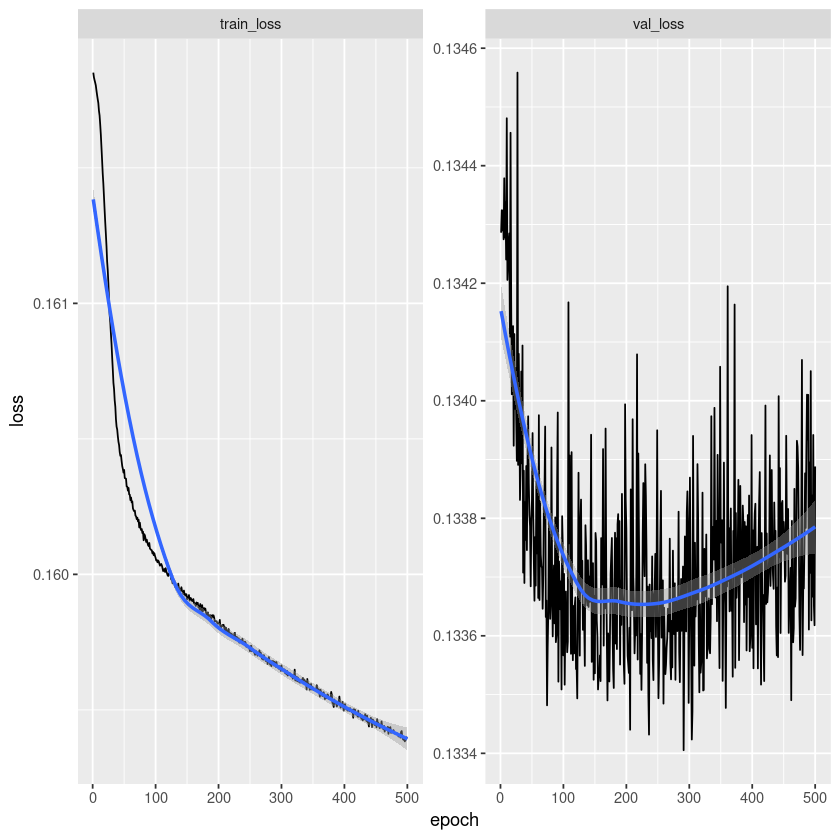

In [70]:
plot(fit)

plot_loss(x=fit[[2]])

## Evaluation



In [71]:
# calculating the predictions
train$fitCANN <- as.vector(model_cann %>% predict(list(Xtrain, VehBrandtrain, Regiontrain, Vtrain)))
test$fitCANN <- as.vector(model_cann %>% predict(list(Xtest, VehBrandtest, Regiontest, Vtest)))

# average in-sample and out-of-sample losses (in 10^(-2))
sprintf("100 x Poisson deviance shallow network (train): %s", PoissonDeviance(train$fitCANN, as.vector(unlist(train$ClaimNb))))
sprintf("100 x Poisson deviance shallow network (test): %s", PoissonDeviance(test$fitCANN, as.vector(unlist(test$ClaimNb))))

# average frequency
sprintf("Average frequency (test): %s", round(sum(test$fitCANN) / sum(test$Exposure), 4))

[1] "100 x Poisson deviance shallow network (train): 23.6721781016215"

[1] "100 x Poisson deviance shallow network (test): 23.9723400221007"

[1] "Average frequency (test): 0.0773"

In [72]:
trainable_params <- sum(unlist(lapply(model_cann$trainable_weights, k_count_params)))
df_cmp %<>% bind_rows(
  data.frame(model = "M4: EmbCANN", epochs = epochs,
             run_time = round(exec_time[[3]], 0), parameters = trainable_params,
             in_sample_loss = round(PoissonDeviance(train$fitCANN, as.vector(unlist(train$ClaimNb))), 4),
             out_sample_loss = round(PoissonDeviance(test$fitCANN, as.vector(unlist(test$ClaimNb))), 4),
             avg_freq = round(sum(test$fitCANN)/sum(test$Exposure), 4)
  ))
df_cmp

model,epochs,run_time,parameters,in_sample_loss,out_sample_loss,avg_freq
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M1: GLM,NA,21,48,24.0875,24.1666,0.0737
M2: Deep Plain Network,300,74,1266,23.6493,24.0045,0.0739
M3: EmbNN,500,125,792,23.6859,23.8739,0.0765
M4: EmbCANN,500,121,792,23.6722,23.9723,0.0773


## Visualizations



The embedding layers have an other advantage, namely, we can graphically illustrate the findings of the network (at least if $d$ is small). This is very useful in NLP as it allows us to explore similar words graphically in 2 or 3 dimensions, after some further dimension reduction techniques have
been applied.

We illustrate below the resulting embedding weights. We observe clustering in both categorical labels, which indicates that some labels could be merged. For $\texttt{VehBrand}$ we observe that car brand $B_{12}$ is diferent from all other car brands, $B_{10}$ and $B_{11}$ seem to have similarities, and the remaining car brands cluster. For $\texttt{Region}$ the result is more diverse.

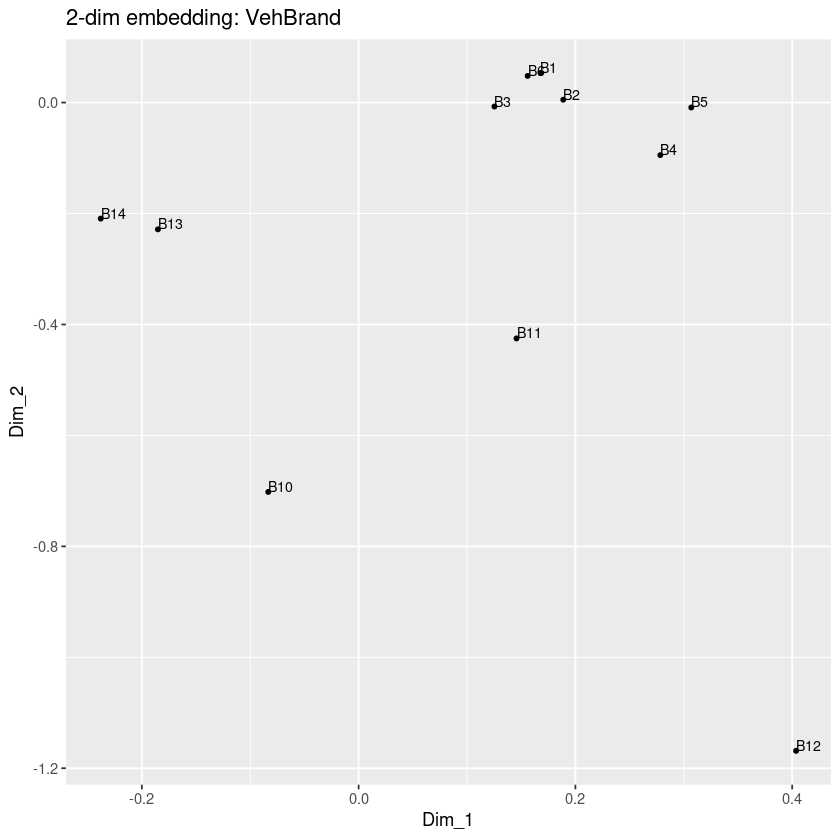

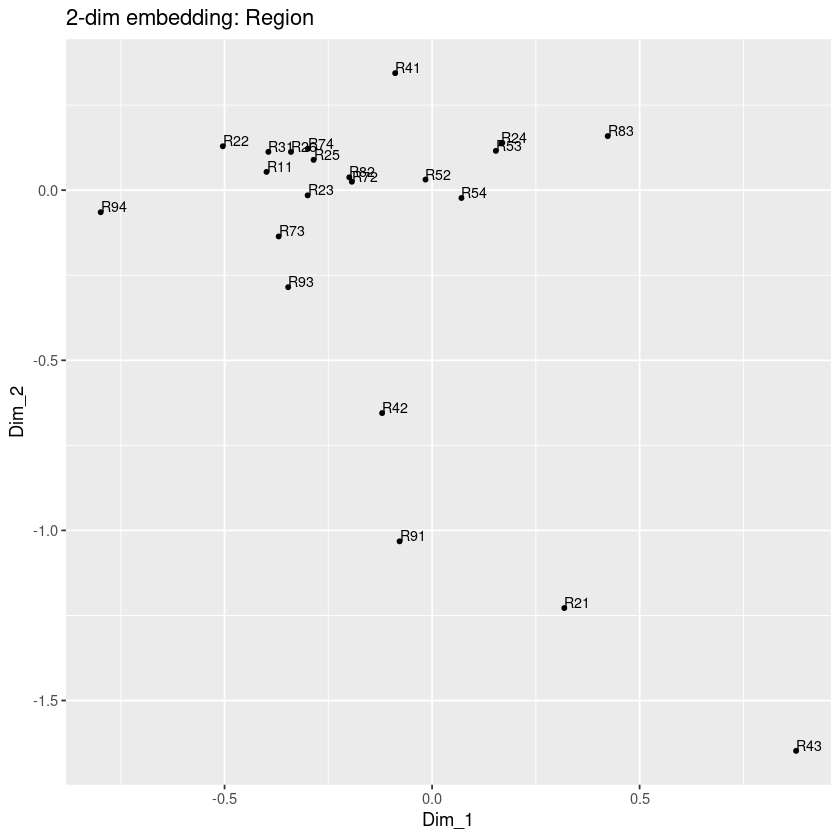

In [73]:
## VehBrand
emb_Brand <- (model_cann$get_layer("BrandEmb") %>% get_weights())[[1]] %>%
  as.data.frame() %>%
  add_column(levels(factor(dat2$VehBrand))) %>%
  rlang::set_names(c("Dim_1", "Dim_2", "Label"))

ggplot(emb_Brand, aes(x = Dim_1, y = Dim_2, label = Label)) +
  geom_point(size = 1) +
  geom_text(aes(label = Label), hjust = 0, vjust = 0, size = 3) +
  ggtitle("2-dim embedding: VehBrand")

## Region
emb_Region <- (model_cann$get_layer("RegionEmb") %>% get_weights())[[1]] %>%
  as.data.frame() %>%
  add_column(levels(factor(dat2$Region))) %>%
  rlang::set_names(c("Dim_1", "Dim_2", "Label"))

ggplot(emb_Region, aes(x = Dim_1, y = Dim_2, label = Label)) +
  geom_point(size = 1) +
  geom_text(aes(label = Label), hjust = 0, vjust = 0, size = 3) +
  ggtitle("2-dim embedding: Region")


## Calibration



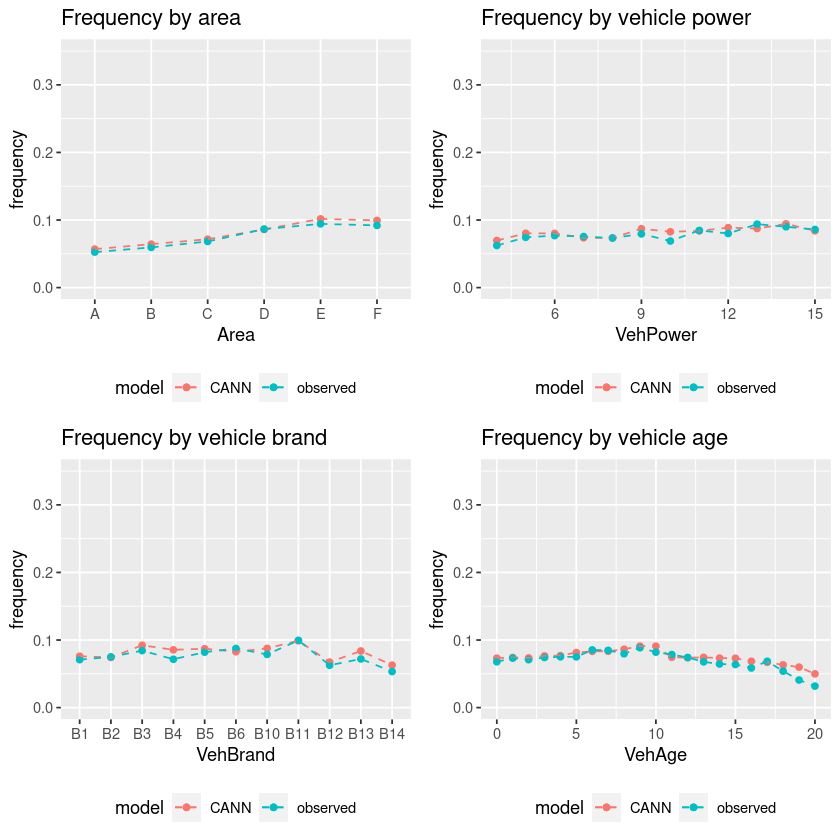

In [74]:
# Area
out <- test %>% group_by(Area) %>%
  summarize(obs = sum(ClaimNb) / sum(Exposure), pred = sum(fitCANN) / sum(Exposure))
p1 <- plot_freq(out, "Area", "Frequency by area", "CANN")
# VehPower
out <- test %>% group_by(VehPower) %>%
  summarize(obs = sum(ClaimNb) / sum(Exposure), pred = sum(fitCANN) / sum(Exposure))
p2 <- plot_freq(out, "VehPower", "Frequency by vehicle power", "CANN")
# VehBrand
out <- test %>% group_by(VehBrand) %>%
  summarize(obs = sum(ClaimNb) / sum(Exposure), pred = sum(fitCANN) / sum(Exposure))
p3 <- plot_freq(out, "VehBrand", "Frequency by vehicle brand", "CANN")
# VehAge
out <- test %>% group_by(VehAge) %>%
  summarize(obs = sum(ClaimNb) / sum(Exposure), pred = sum(fitCANN) / sum(Exposure))
p4 <- plot_freq(out, "VehAge", "Frequency by vehicle age", "CANN")

grid.arrange(p1, p2, p3, p4)

We would like to emphasize that the CANN aproach is by no means restricted to the GLM. In fact, we can choose any regression model for the skip connection, for instance, we can replace the GLM prediction by a generalized additive model (GAM) prediction in the working weight denition. This is exactly the idea behind the Poisson boosting machine.
Please find further details in the tutorial on [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3320525).

# Model 5: GAM

This model has not been discussed in the theoretical part and goes beyond the scope of the course, so do not hesitate to skip it. Details about this model can be found in the tutorial https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3320525, p. 23ff.

The marginal modeling used in Model GLM2 can be (slightly) improved, but it does not explain the big differences between Model GLM2 and the neural network models. Therefore, the major weakness of Model GLM2 compared to the neural network models must come from missing interactions in the former model. Note that in this former model all interactions are of multiplicative type between the feature components. This deficiency is going to be explored next. 

For all our subsequent derivations we enhance Model GLM2 by improving the marginal modeling of the feature components VehAge and BonusMalus using a joint GAM adjustment. That is, we consider the regression function

![3_cann](Figure_gam.PNG)

where the first term on the right-hand side (scalar product) is the part originating from Model GLM2, and $ns^2_1$ and $ns^2_2$ are two natural cubic splines enhancing Model GLM2 by GAM features. We fit these two natural cubic splines simultaneously using the GAM framework and we call this improvement Model GAM1. The corresponding code is given below. We compress the data w.r.t. the two selected feature components VehAge and BonusMalus, and we fit the natural cubic splines for these two variables using the logged working weights $log(v^{GLM}_i)$ as offsets.

## Definition and Fitting

In [75]:
exec_time <- system.time({
  datGAM <- train %>% group_by(VehAge, BonusMalus) %>% summarize(fitGLM2 = sum(fitGLM2), ClaimNb = sum(ClaimNb))
  gam1 <- gam(ClaimNb ~ s(VehAge, bs="cr") + s(BonusMalus, bs="cr"), data = datGAM, method = "GCV.Cp", offset = log(fitGLM2), family = poisson)
})
exec_time[1:5]

summary(gam1)

user.self   sys.self    elapsed user.child  sys.child 
     0.295      0.000      0.296      0.000      0.000


Family: poisson 
Link function: log 

Formula:
ClaimNb ~ s(VehAge, bs = "cr") + s(BonusMalus, bs = "cr")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.01309    0.01296    1.01    0.313

Approximate significance of smooth terms:
                edf Ref.df Chi.sq p-value    
s(VehAge)     8.495  8.917  79.63  <2e-16 ***
s(BonusMalus) 8.716  8.966 858.44  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.985   Deviance explained = 21.9%
UBRE = 1.2258  Scale est. = 1         n = 1455

## Evaluation



In [76]:
# Predictions
train$fitGAM1 <- exp(predict(gam1, newdata = train)) * train$fitGLM2
test$fitGAM1 <- exp(predict(gam1, newdata = test)) * test$fitGLM2
dat$fitGAM1 <- exp(predict(gam1, newdata = dat)) * dat$fitGLM2

In [77]:
# in-sample and out-of-sample losses (in 10^(-2))
sprintf("100 x Poisson deviance GLM (train): %s", PoissonDeviance(train$fitGAM1, train$ClaimNb))
sprintf("100 x Poisson deviance GLM (test): %s", PoissonDeviance(test$fitGAM1, test$ClaimNb))

# Overall estimated frequency
sprintf("average frequency (test): %s", round(sum(test$fitGAM1) / sum(test$Exposure), 4))


[1] "100 x Poisson deviance GLM (train): 23.9215405928447"

[1] "100 x Poisson deviance GLM (test): 24.0234983219794"

[1] "average frequency (test): 0.0737"

In [78]:
df_cmp %<>% bind_rows(
  data.frame(model = "M5: GAM1", epochs = NA,
             run_time = round(exec_time[[3]], 0), parameters = length(coef(glm2)) + round(sum(pen.edf(gam1)), 1),
             in_sample_loss = round(PoissonDeviance(train$fitGAM1, as.vector(unlist(train$ClaimNb))), 4),
             out_sample_loss = round(PoissonDeviance(test$fitGAM1, as.vector(unlist(test$ClaimNb))), 4),
             avg_freq = round(sum(test$fitGAM1) / sum(test$Exposure), 4)
  ))
df_cmp

model,epochs,run_time,parameters,in_sample_loss,out_sample_loss,avg_freq
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M1: GLM,NA,21,48.0,24.0875,24.1666,0.0737
M2: Deep Plain Network,300,74,1266.0,23.6493,24.0045,0.0739
M3: EmbNN,500,125,792.0,23.6859,23.8739,0.0765
M4: EmbCANN,500,121,792.0,23.6722,23.9723,0.0773
M5: GAM1,NA,0,65.2,23.9215,24.0235,0.0737


We see the expected improvement in out-of-sample loss from GLM2 to GAM1 . However, there is still a big gap compared to the neural network approaches. Note that Model GAM1 is based on multiplicative interactions that we are going to challenge next.

# Model 6: GAM improved CANN (gamplus)

This model has not been discussed in the theoretical part and goes beyond the scope of the course, so do not hesitate to skip it. Details about this model can be found in the tutorial https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3320525, p. 23ff.

We may explore missing interactions in the models considered above. As base model we choose Model GAM1, as follows:

![3_cann](Figure_gamplus_ass.PNG)

In (3.11) we define two parallel neural networks that only interact in the last step where we concatenate them by adding up the terms. The reason for the choice is that we did not observe major interactions between the components of the two parallel networks (see tutorial).

## Definition and Compilation

In [79]:
# neural network definitions for model (3.11)
trainX <- list(as.matrix(train[, c("VehPowerX", "VehAgeX", "VehGasX")]),
                as.matrix(train[, "VehBrandX"]),
                as.matrix(train[, c("DrivAgeX", "BonusMalus")]),
                as.matrix(log(train$fitGAM1)) )

testX <- list(as.matrix(test[, c("VehPowerX", "VehAgeX", "VehGasX")]),
                as.matrix(test[, "VehBrandX"]),
                as.matrix(test[, c("DrivAgeX", "BonusMalus")]),
                as.matrix(log(test$fitGAM1)) )

neurons <- c(20, 15, 10)
no_labels <- length(unique(train$VehBrandX))

In [80]:
#  definition of neural network (3.11)

Model2IA <- function(no_labels) {
  Cont1 <- layer_input(shape = c(3), dtype = 'float32', name = 'Cont1')
  Cat1 <- layer_input(shape = c(1), dtype = 'int32', name = 'Cat1')
  Cont2 <- layer_input(shape = c(2), dtype = 'float32', name = 'Cont2')
  LogExposure <- layer_input(shape = c(1), dtype = 'float32', name = 'LogExposure')
  x_input <- c(Cont1, Cat1, Cont2, LogExposure)
  
  Cat1_embed <- Cat1 %>%
    layer_embedding(input_dim = no_labels, output_dim = 2, trainable = TRUE, input_length = 1, name = 'Cat1_embed') %>%
    layer_flatten(name = 'Cat1_flat')
  
  NNetwork1 <- list(Cont1, Cat1_embed) %>% layer_concatenate(name = 'cont') %>%
    layer_dense(units = neurons[1], activation = 'tanh', name = 'hidden1') %>%
    layer_dense(units = neurons[2], activation = 'tanh', name = 'hidden2') %>%
    layer_dense(units = neurons[3], activation = 'tanh', name = 'hidden3') %>%
    layer_dense(units = 1, activation = 'linear', name = 'NNetwork1',
                weights = list(array(0, dim = c(neurons[3], 1)), array(0, dim = 1)))
  
  NNetwork2 <- Cont2 %>%
    layer_dense(units = neurons[1], activation = 'tanh', name = 'hidden4') %>%
    layer_dense(units = neurons[2], activation = 'tanh', name = 'hidden5') %>%
    layer_dense(units = neurons[3], activation = 'tanh', name = 'hidden6') %>%
    layer_dense(units = 1, activation = 'linear', name = 'NNetwork2',
                weights = list(array(0, dim = c(neurons[3], 1)), array(0, dim = 1)))
  
  NNoutput <- list(NNetwork1, NNetwork2, LogExposure) %>% layer_add(name = 'Add') %>%
    layer_dense(units = 1, activation = k_exp, name = 'NNoutput', trainable = FALSE,
                weights = list(array(c(1), dim = c(1, 1)), array(0, dim = 1)))
  
  model <- keras_model(inputs = x_input, outputs = c(NNoutput))
  
  model %>% compile(optimizer = optimizer_nadam(),
                    loss = 'poisson')
  
  model
}

model_gamplus <- Model2IA(no_labels)

summary(model_gamplus)


Model: "model_3"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
Cat1 (InputLayer)         [(None, 1)]       0                                   
________________________________________________________________________________
Cat1_embed (Embedding)    (None, 1, 2)      22       Cat1[0][0]                 
________________________________________________________________________________
Cont1 (InputLayer)        [(None, 3)]       0                                   
________________________________________________________________________________
Cat1_flat (Flatten)       (None, 2)         0        Cat1_embed[0][0]           
________________________________________________________________________________
cont (Concatenate)        (None, 5)         0        Cont1[0][0]                
                                                     Cat1_flat[0][0]            
___________

## Fitting



In [81]:
# select number of epochs and batch_size
epochs <- 100
batch_size <- 10000
verbose <- 1

In [82]:
# expected run-time on Renku 8GB environment around 65 seconds
# may take a couple of minutes if epochs is more than 100
exec_time <- system.time(
 fit <- model_gamplus %>% fit(trainX, as.matrix(train$ClaimNb),
                          epochs = epochs,
                          batch_size = batch_size,
                          verbose = verbose, 
                          validation_data = list(testX, as.matrix(test$ClaimNb)))
)
exec_time[1:5]


user.self   sys.self    elapsed user.child  sys.child 
   138.081     20.508     31.718      0.000      0.000

`geom_smooth()` using formula 'y ~ x'



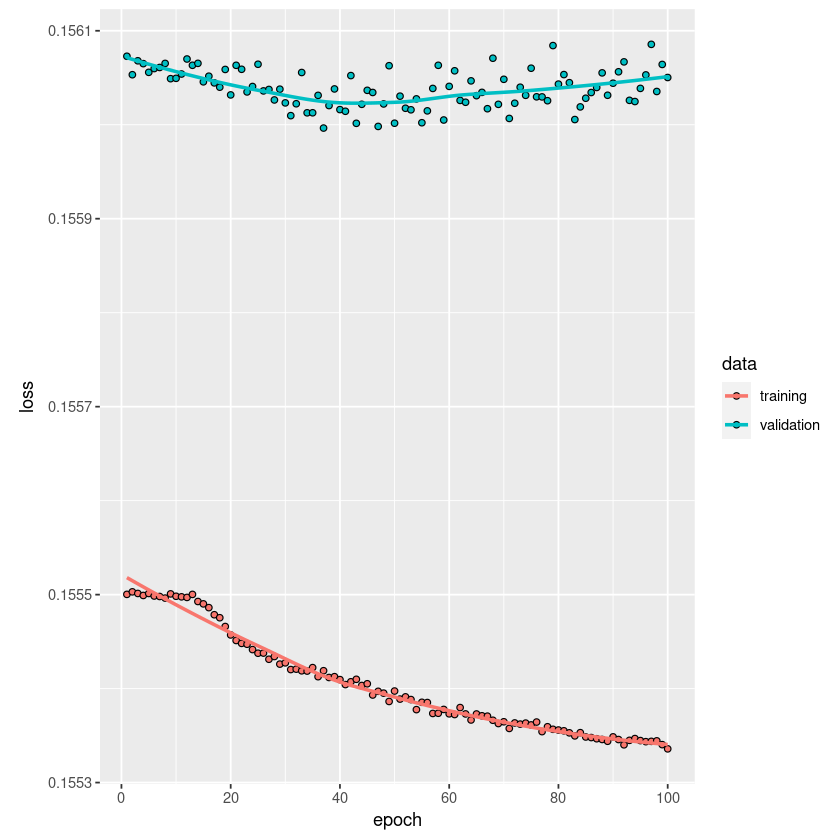

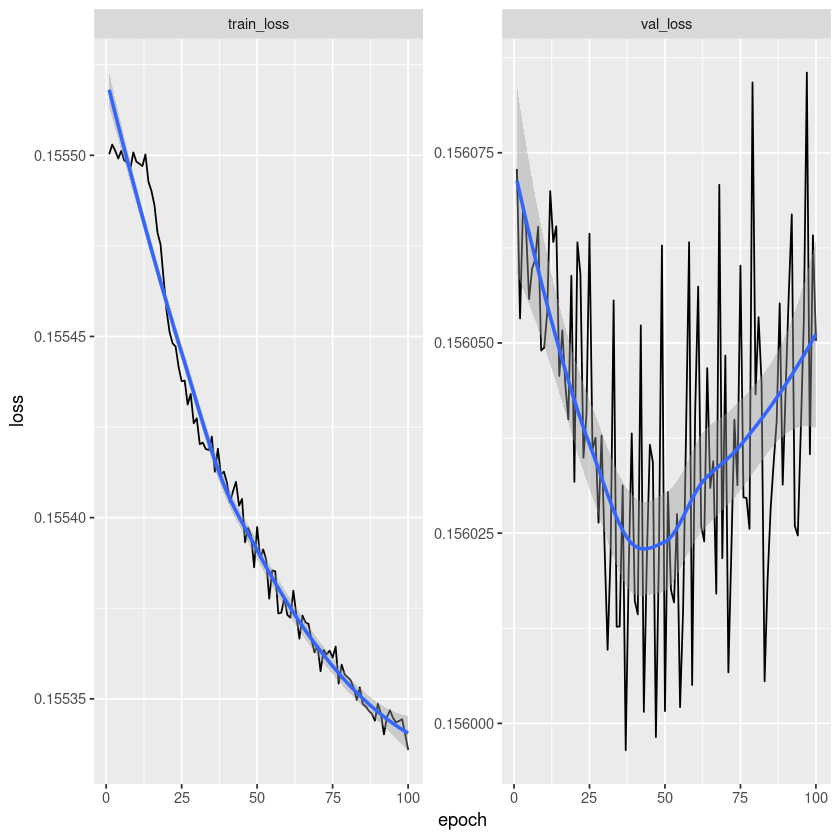

In [83]:
plot(fit)

plot_loss(x=fit[[2]])

As both validation and training are decreasing, the number of epochs needs to be increased to find the optimal number of epochs.

## Evaluation



In [84]:
# calculating the predictions
train$fitGAMPlus <- as.vector(model_gamplus %>% predict(trainX))
test$fitGAMPlus <- as.vector(model_gamplus %>% predict(testX))

# average in-sample and out-of-sample losses (in 10^(-2))
sprintf("100 x Poisson deviance shallow network (train): %s", PoissonDeviance(train$fitGAMPlus, as.vector(unlist(train$ClaimNb))))
sprintf("100 x Poisson deviance shallow network (test): %s", PoissonDeviance(test$fitGAMPlus, as.vector(unlist(test$ClaimNb))))

# average frequency
sprintf("Average frequency (test): %s", round(sum(test$fitGAMPlus) / sum(test$Exposure), 4))

[1] "100 x Poisson deviance shallow network (train): 23.8862918907072"

[1] "100 x Poisson deviance shallow network (test): 24.0247987478582"

[1] "Average frequency (test): 0.0742"

In [85]:
trainable_params <- sum(unlist(lapply(model_gamplus$trainable_weights, k_count_params)))
df_cmp %<>% bind_rows(
  data.frame(model = "M6: GAM+", epochs = epochs,
             run_time = round(exec_time[[3]], 0), parameters = trainable_params,
             in_sample_loss = round(PoissonDeviance(train$fitGAMPlus, as.vector(unlist(train$ClaimNb))), 4),
             out_sample_loss = round(PoissonDeviance(test$fitGAMPlus, as.vector(unlist(test$ClaimNb))), 4),
             avg_freq = round(sum(test$fitGAMPlus) / sum(test$Exposure), 4)
  ))
df_cmp

model,epochs,run_time,parameters,in_sample_loss,out_sample_loss,avg_freq
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M1: GLM,NA,21,48.0,24.0875,24.1666,0.0737
M2: Deep Plain Network,300,74,1266.0,23.6493,24.0045,0.0739
M3: EmbNN,500,125,792.0,23.6859,23.8739,0.0765
M4: EmbCANN,500,121,792.0,23.6722,23.9723,0.0773
M5: GAM1,NA,0,65.2,23.9215,24.0235,0.0737
M6: GAM+,100,32,1174.0,23.8863,24.0248,0.0742


We observe excellent fitting results of Model GAM+ compared to the other neural network models. This illustrates that in (3.11) we capture the main interaction terms.

## Calibration



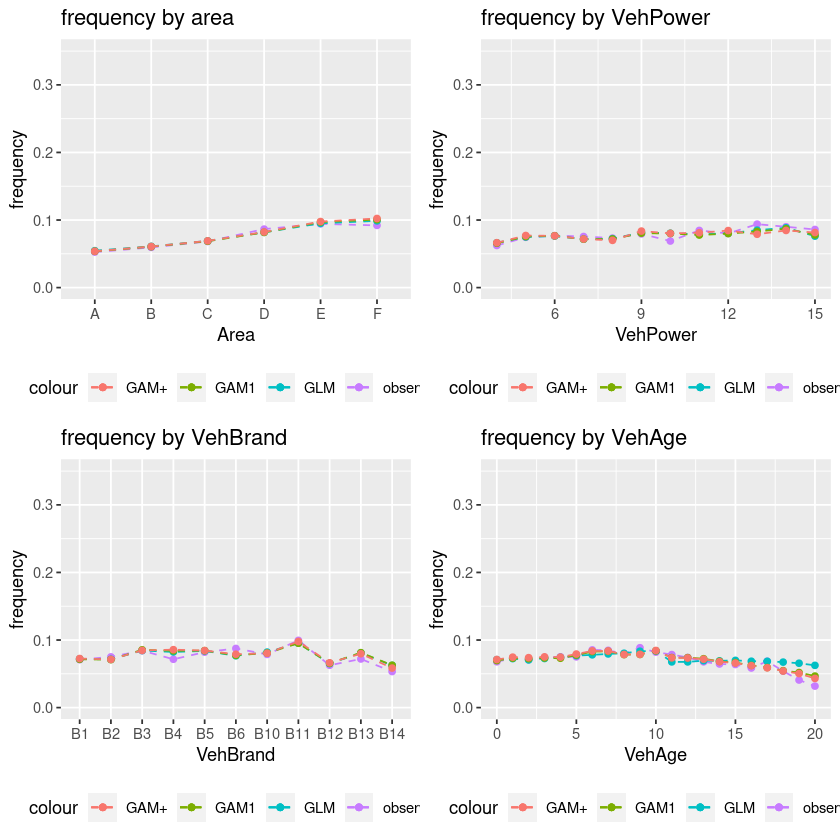

In [86]:
plot_freq_multi <- function(xvar, title) {
  out <- test %>% group_by(!!sym(xvar)) %>% summarize(
    obs = sum(ClaimNb) / sum(Exposure),
    glm = sum(fitGLM2) / sum(Exposure),
    gam = sum(fitGAM1) / sum(Exposure),
    gamp = sum(fitGAMPlus) / sum(Exposure)
  )
  ggplot(out, aes(x = !!sym(xvar), group = 1)) +
    geom_point(aes(y = obs, colour = "observed")) + geom_line(aes(y = obs, colour = "observed"), linetype = "dashed") +
    geom_point(aes(y = glm, colour = "GLM")) + geom_line(aes(y = glm, colour = "GLM"), linetype = "dashed") +
    geom_point(aes(y = gam, colour = "GAM1")) + geom_line(aes(y = gam, colour = "GAM1"), linetype = "dashed") +
    geom_point(aes(y = gamp, colour = "GAM+")) + geom_line(aes(y = gamp, colour = "GAM+"), linetype = "dashed") +
    ylim(0, 0.35) + labs(x = xvar, y = "frequency", title = title) + theme(legend.position = "bottom")
}
# Area
p1 <- plot_freq_multi("Area", "frequency by area")
# VehPower
p2 <- plot_freq_multi("VehPower", "frequency by VehPower")
# VehBrand
p3 <- plot_freq_multi("VehBrand", "frequency by VehBrand")
# VehAge
p4 <- plot_freq_multi("VehAge", "frequency by VehAge")

grid.arrange(p1, p2, p3, p4)


# Further networks architectures

So far, we have fitted three different network architecture and we are comparing their performance and quality of fit. 

As mentioned above, one can amend and change hyperparameters (optimizer, batch size, epochs,...) and see how the results change.

One can also change the neural network architecture, e.g.
* change the number of layers and neurons
* add additional layers, e.g. normalization layers
* add ridge regularization

See:
* the keras cheat sheet https://github.com/rstudio/cheatsheets/raw/master/keras.pdf.
* the tutorial: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3226852

**Exercise:** Have a look at the keras cheat sheet, study the normalization layer and add them and compare the results.

**Exercise:** Look at other layers, try to understand them and compare the impact of these layers.

**Exercise:** Apply ridge regularization, understand what it is and compare the results.

With fitting neural networks, there are a couple of questions arising, and we like to share some of our experience here:
- The choice of the architecture can be considered more as art than science
- Neural networks move the challenge of feature engineering (which the network learns) to the challenge of selecting the architecture.
- There are a few rules of thumb on the architecture:
    - For structured data, only 3-5 layers are required, more layers do not improve the accuracy further
    - For finding interactions, the third and higher layers are "considering" them. The first two are for the "main effects"
    - In this tutorial on [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3226852), there is a proposal how to choose the optimal batch size for insurance pricing data, see formula (4.5) on p. 25.
- The treatment of missing values is an open question. 

# Model Comparison

Comparison of various metrics for the models.


In [87]:
df_cmp

model,epochs,run_time,parameters,in_sample_loss,out_sample_loss,avg_freq
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M1: GLM,NA,21,48.0,24.0875,24.1666,0.0737
M2: Deep Plain Network,300,74,1266.0,23.6493,24.0045,0.0739
M3: EmbNN,500,125,792.0,23.6859,23.8739,0.0765
M4: EmbCANN,500,121,792.0,23.6722,23.9723,0.0773
M5: GAM1,NA,0,65.2,23.9215,24.0235,0.0737
M6: GAM+,100,32,1174.0,23.8863,24.0248,0.0742


We can draw the following conclusions:
- We see that the performance of the models is quite similar comparing the out-of-sample losses.
- We observe that the performance of all network models with embedding layers are better in out-of-sample losses.
- Th CANN approach does lead to an improvement over the classical network approach in terms of out-of-sample losses. The main issue in the current set-up is that Model GLM2 is not suffciently good so that the CANN approach could benefit from a very good initial model. In fact, we are penalized here for not having invested suffcient efforts in building a good GLM. However, the CANN approach will allow us to explicitly analyze the weaknesses of Model GLM2.
- It is not yet generally known to us if the embedded models provide better performance in terms of out-of-sample losses. Here it is the case.
- We have also learned that embedding layers can lead to a more effcient treatment of categorical variables compared to dummy coding and one-hot encoding.
- One can use the CANN approach to systematically find missing interactions in the GAM improved GLM regression function. These missing interactions are of nonmultiplicative type because the GAM-GLM approach considers multiplicative interactions in the regression function. These steps lead to a systematic use of neural networks, in particular, they are systematically used to identify weaknesses of existing regression models.
- The fitted average claim frequency differs between the neural network models. This is different when comparing GLM's and GAM's (see the glm tutorial on the same data) where the predicted claim frequency is the same for all models. This is the so called **bias regularization** issue of neural networks, which is discussed in the tutorial, section 6.5.
- We see that the $\texttt{freqMTPL2freq}$ dataset is maybe not ideal and not representative for a standard primary insurance pricing dataset, due to:
    - The performance of the various models is quite similar and there are not many areas with highly different predictions.
    - The marginal predicted frequencies do not vary much accross the various cateogorical feature levels.
    - The goal of the tutorial is more to demonstrate the techniques and compare them rather to nicely identify important features.

## Calibration



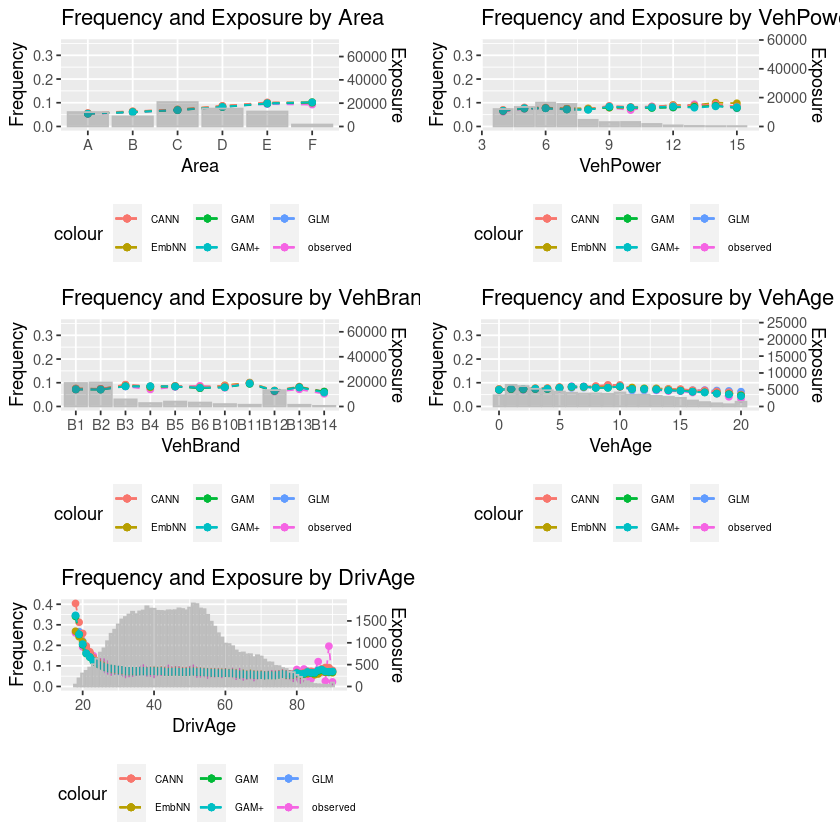

In [88]:
plot_cmp <- function(xvar, title, maxlim = 0.35) {
  out <- test %>% group_by(!!sym(xvar)) %>% summarize(
    vol = sum(Exposure),
    obs = sum(ClaimNb) / sum(Exposure),
    glm = sum(fitGLM2) / sum(Exposure),
    nn = sum(fitNN) / sum(Exposure),
    cann = sum(fitCANN) / sum(Exposure),
    gam = sum(fitGAM1) / sum(Exposure),
    gamplus = sum(fitGAMPlus) / sum(Exposure)
  )
  
  max_pri <- max(out$obs, out$glm, out$nn, out$cann, out$gam, out$gamplus)
  max_sec <- max(out$vol)
  max_ratio <- max_pri / max_sec
  
  if (is.null(maxlim)) maxlim <- max_pri
  
  ggplot(out, aes(x = !!sym(xvar), group = 1)) +
    geom_point(aes(y = obs, colour = "observed")) + geom_line(aes(y = obs, colour = "observed"), linetype = "dashed") +
    geom_point(aes(y = glm, colour = "GLM")) + geom_line(aes(y = glm, colour = "GLM"), linetype = "dashed") +
    geom_point(aes(y = nn, colour = "EmbNN")) + geom_line(aes(y = nn, colour = "EmbNN"), linetype = "dashed") +
    geom_point(aes(y = cann, colour = "CANN")) + geom_line(aes(y = cann, colour = "CANN"), linetype = "dashed") +
    geom_point(aes(y = gam, colour = "GAM")) + geom_line(aes(y = gam, colour = "GAM"), linetype = "dashed") +
    geom_point(aes(y = gamplus, colour = "GAM+")) + geom_line(aes(y = gamplus, colour = "GAM+"), linetype = "dashed") +
    geom_bar(aes(y = vol * (max_ratio)), colour = "grey", stat = "identity", alpha = 0.3) +
    scale_y_continuous(name = "Frequency", sec.axis = sec_axis( ~ . / (max_ratio), name = "Exposure"), limits = c(0, maxlim)) +
    labs(x = xvar, title = title) + theme(legend.position = "bottom", legend.text = element_text(size = 6))
}

# Area
p1 <- plot_cmp("Area", "Frequency and Exposure by Area")
# VehPower
p2 <- plot_cmp("VehPower", "Frequency and Exposure by VehPower")
# VehBrand
p3 <- plot_cmp("VehBrand", "Frequency and Exposure by VehBrand")
# VehAge
p4 <- plot_cmp("VehAge", "Frequency and Exposure by VehAge")
# DrivAge plot with exposure distribution
p5 <- plot_cmp("DrivAge", "Frequency and Exposure by DrivAge", maxlim = NULL)

grid.arrange(p1, p2, p3, p4, p5)


Some further exercises:

**Exercise:** Fit a CANN without embeddings (based on Model 2) and compare the results.

**Exercise:** Increase the number of epochs (requiring longer computation time) to find the optimal number of epochs for every model.

Out-of-sample claims frequency predictions (on log-scales) comparison.



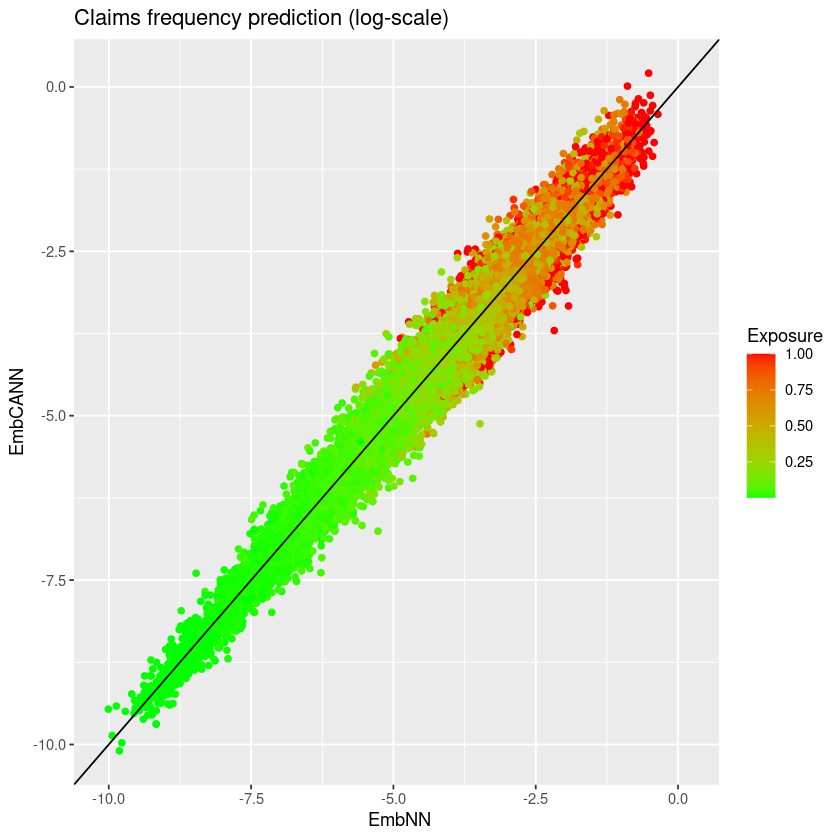

In [89]:
axis_min <- log(max(test$fitCANN, test$fitNN))
axis_max <- log(min(test$fitCANN, test$fitNN))

ggplot(test, aes(x = log(fitNN), y = log(fitCANN), colour = Exposure)) + geom_point() +
  geom_abline(colour = "#000000", slope = 1, intercept = 0) +
  xlim(axis_max, axis_min) + ylim(axis_max, axis_min) +
  labs(x = " EmbNN", y = "EmbCANN", title = "Claims frequency prediction (log-scale)") +
  scale_colour_gradient(low = "green", high = "red")


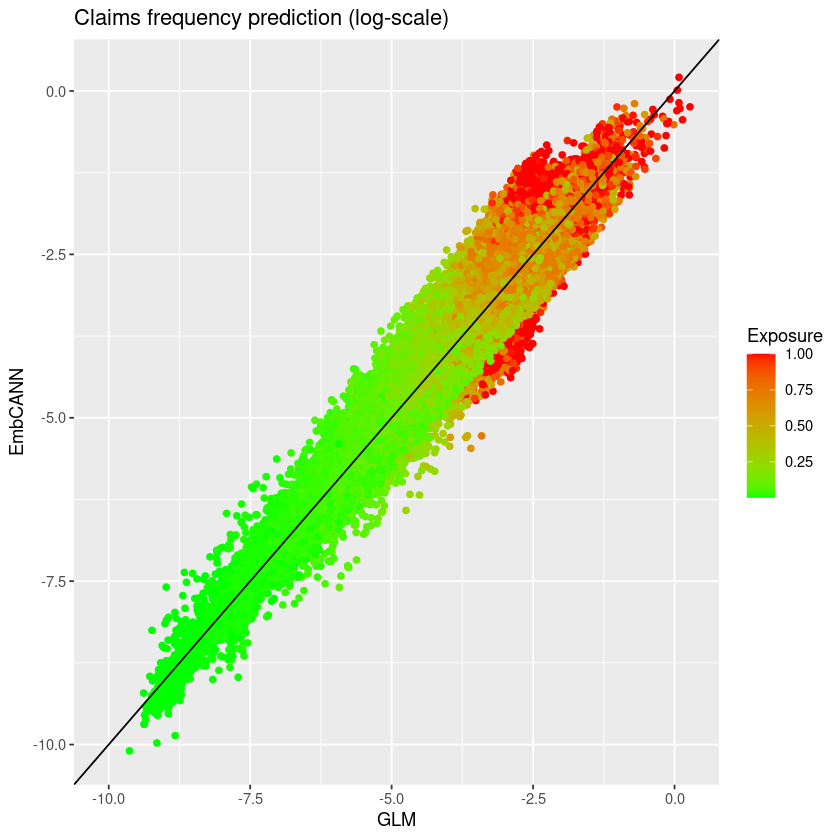

In [90]:
axis_min <- log(max(test$fitCANN, test$fitGLM2))
axis_max <- log(min(test$fitCANN, test$fitGLM2))

ggplot(test, aes(x = log(fitGLM2), y = log(fitCANN), colour = Exposure)) + geom_point() +
  geom_abline(colour = "#000000", slope = 1, intercept = 0) +
  xlim(axis_max, axis_min) + ylim(axis_max, axis_min) +
  labs(x = "GLM", y = "EmbCANN", title = "Claims frequency prediction (log-scale)") +
  scale_colour_gradient(low = "green", high = "red")


# Session Info

The html is generated with the follow packages (which migth be slightly newer than the ones used in the published tutorial).

In [91]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] tidyr_1.1.2      splitTools_0.3.1 gridExtra_2.3    ggplot2_3.3.3   
 [5] purrr_0.3.4      tibble_3.0.5     dplyr_1.0.3      magrittr_2.0.1  
 [9] keras_2.3.0.0    mgcv_1.8-33      nlme_3.1-151    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.6       

In [92]:
reticulate::py_config()

python:         /usr/bin/python3
libpython:      /usr/lib/python3.8/config-3.8-x86_64-linux-gnu/libpython3.8.so
pythonhome:     //usr://usr
version:        3.8.10 (default, Jun  2 2021, 10:49:15)  [GCC 9.4.0]
numpy:          /usr/local/lib/python3.8/dist-packages/numpy
numpy_version:  1.20.1
tensorflow:     /usr/local/lib/python3.8/dist-packages/tensorflow

python versions found: 
 /usr/bin/python3
 /usr/bin/python

In [93]:
tensorflow::tf_version()

[1] ‘2.4’

# References

* https://tensorflow.rstudio.com/guide/
* https://github.com/rstudio/cheatsheets/raw/master/keras.pdf
* https://cran.r-project.org/web/packages/keras/vignettes/guide_keras.html
* https://keras.rstudio.com/articles/about_keras_models.html
* https://keras.rstudio.com/articles/functional_api.html
* https://cran.rstudio.com/web/packages/keras/vignettes/sequential_model.html
* https://www.rdocumentation.org/packages/keras/versions/2.3.0.0/topics/layer_dense
* https://www.rdocumentation.org/packages/keras/versions/2.1.6/topics/compile